In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


# Data Prepping and Split

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

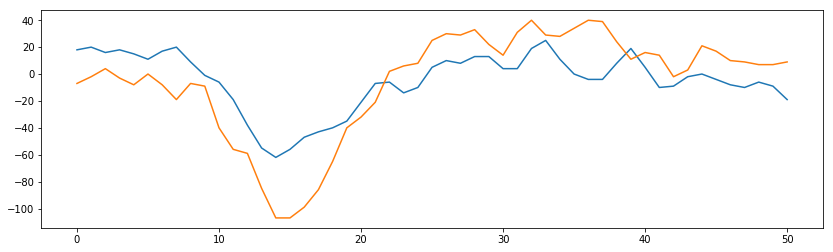

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [9]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [10]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (26260, 51)
Test Datasize: (6566, 51)


# Helper Functions

In [11]:
def find_scaled_mse(original, recons, params):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    print(params, np.median(mse))
    mse = np.array(mse)
    return mse

In [12]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [13]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(7,5))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

In [14]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder

In [15]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [16]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])

    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data)
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [17]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        x = np.zeros((batch_size, 51))
        for i, feats in enumerate(selected):
            x[i, :] = input_data[feats, :]
        x = torch.from_numpy(x).float().cuda()
        #---------FORWARD------------#
        enc, out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, x)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, avg:{:.8f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple Shallow

In [18]:
# input -> 50 -> 12 -> emb -> 12 -> 50 -> input

class autoencoder_shallow(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_shallow, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 50),
                                     activation_layer,
                                     nn.Linear(50, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 50),
                                     activation_layer,
                                     nn.Linear(50, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [19]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_14 = autoencoder_shallow(length, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_12 = autoencoder_shallow(length, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12 = train_ae(ae_12, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_1_4', np.array(losses_14))
np.save('models/final_models/losses_1_2', np.array(losses_12))


# Saving Models
#torch.save(ae_14, 'models/final_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_12, 'models/final_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 6525
epoch [1/350000], loss:1595.88757324, avg:1595.88757324
epoch [101/350000], loss:1542.09216309, avg:1562.66638184
epoch [201/350000], loss:1316.36938477, avg:1354.29528809
epoch [301/350000], loss:689.42193604, avg:702.54589844
epoch [401/350000], loss:303.32797241, avg:310.09399414
epoch [501/350000], loss:245.92134094, avg:249.37165833
epoch [601/350000], loss:228.37178040, avg:236.17048645
epoch [701/350000], loss:230.30468750, avg:230.67015076
epoch [801/350000], loss:237.01640320, avg:233.59683228
epoch [901/350000], loss:216.91470337, avg:226.38684082
epoch [1001/350000], loss:216.04193115, avg:214.63267517
epoch [1101/350000], loss:190.12145996, avg:192.59062195
epoch [1201/350000], loss:171.23294067, avg:178.76095581
epoch [1301/350000], loss:173.07316589, avg:168.42803955
epoch [1401/350000], loss:161.74569702, avg:161.99916077
epoch [1501/350000], loss:171.03527832, avg:159.72050476
epoch [1601/350000], loss:155.78491211, avg:153.90428162
epoc

epoch [14301/350000], loss:136.45800781, avg:130.52684021
epoch [14401/350000], loss:126.53385925, avg:128.50903320
epoch [14501/350000], loss:129.87086487, avg:129.19302368
epoch [14601/350000], loss:130.37339783, avg:128.99713135
epoch [14701/350000], loss:119.41680908, avg:128.73249817
epoch [14801/350000], loss:138.38671875, avg:127.51281738
epoch [14901/350000], loss:139.43879700, avg:131.57254028
epoch [15001/350000], loss:120.92218781, avg:129.03237915
epoch [15101/350000], loss:124.79499817, avg:128.77728271
epoch [15201/350000], loss:128.56314087, avg:127.35039520
epoch [15301/350000], loss:133.10859680, avg:131.00160217
epoch [15401/350000], loss:132.44842529, avg:129.75144958
epoch [15501/350000], loss:120.12902832, avg:128.70060730
epoch [15601/350000], loss:138.32017517, avg:128.64422607
epoch [15701/350000], loss:126.93933868, avg:129.13458252
epoch [15801/350000], loss:134.65948486, avg:131.60266113
epoch [15901/350000], loss:130.37724304, avg:129.28747559
epoch [16001/3

epoch [28501/350000], loss:128.66503906, avg:127.30382538
epoch [28601/350000], loss:123.99607849, avg:127.65352631
epoch [28701/350000], loss:121.52213287, avg:125.87391663
epoch [28801/350000], loss:137.15826416, avg:128.56547546
epoch [28901/350000], loss:130.75831604, avg:127.35405731
epoch [29001/350000], loss:133.67628479, avg:129.58482361
epoch [29101/350000], loss:130.15916443, avg:128.96595764
epoch [29201/350000], loss:118.61460876, avg:125.85335541
epoch [29301/350000], loss:128.67869568, avg:123.29559326
epoch [29401/350000], loss:139.29356384, avg:129.48490906
epoch [29501/350000], loss:134.37454224, avg:128.37113953
epoch [29601/350000], loss:121.70067596, avg:124.36897278
epoch [29701/350000], loss:127.37705994, avg:126.11467743
epoch [29801/350000], loss:121.43502808, avg:125.26057434
epoch [29901/350000], loss:133.33500671, avg:130.73722839
epoch [30001/350000], loss:143.41607666, avg:129.53019714
epoch [30101/350000], loss:136.61387634, avg:126.42614746
epoch [30201/3

epoch [42701/350000], loss:127.68663025, avg:125.72528076
epoch [42801/350000], loss:118.23176575, avg:123.17467499
epoch [42901/350000], loss:124.06123352, avg:125.35717010
epoch [43001/350000], loss:126.63970947, avg:128.39408875
epoch [43101/350000], loss:120.16099548, avg:128.93585205
epoch [43201/350000], loss:129.16381836, avg:129.02043152
epoch [43301/350000], loss:125.44155121, avg:127.78594971
epoch [43401/350000], loss:124.06157684, avg:125.13109589
epoch [43501/350000], loss:131.04809570, avg:125.18192291
epoch [43601/350000], loss:123.38822174, avg:124.08705902
epoch [43701/350000], loss:129.69926453, avg:124.78197479
epoch [43801/350000], loss:124.15281677, avg:129.69581604
epoch [43901/350000], loss:118.01402283, avg:125.26348114
epoch [44001/350000], loss:127.56526184, avg:125.70867920
epoch [44101/350000], loss:132.29968262, avg:126.37761688
epoch [44201/350000], loss:122.28610992, avg:126.13535309
epoch [44301/350000], loss:129.27810669, avg:129.72982788
epoch [44401/3

epoch [56901/350000], loss:121.61173248, avg:128.01379395
epoch [57001/350000], loss:130.18949890, avg:131.82267761
epoch [57101/350000], loss:131.10569763, avg:125.40504456
epoch [57201/350000], loss:130.52996826, avg:127.85405731
epoch [57301/350000], loss:130.72200012, avg:127.08786774
epoch [57401/350000], loss:123.07040405, avg:125.98992920
epoch [57501/350000], loss:124.28307343, avg:127.49478912
epoch [57601/350000], loss:123.81829071, avg:126.20971680
epoch [57701/350000], loss:128.09568787, avg:128.29956055
epoch [57801/350000], loss:127.43172455, avg:126.57071686
epoch [57901/350000], loss:116.79611969, avg:126.60790253
epoch [58001/350000], loss:125.65937805, avg:126.06502533
epoch [58101/350000], loss:118.59053040, avg:125.02899170
epoch [58201/350000], loss:122.38137054, avg:125.88099670
epoch [58301/350000], loss:137.14523315, avg:124.16060638
epoch [58401/350000], loss:129.03071594, avg:128.99145508
epoch [58501/350000], loss:136.18504333, avg:125.70056152
epoch [58601/3

epoch [71101/350000], loss:127.83088684, avg:124.76596832
epoch [71201/350000], loss:123.81862640, avg:127.29343414
epoch [71301/350000], loss:128.21501160, avg:124.82671356
epoch [71401/350000], loss:125.76268005, avg:124.32895660
epoch [71501/350000], loss:117.63051605, avg:123.30812836
epoch [71601/350000], loss:118.26238251, avg:122.43717194
epoch [71701/350000], loss:127.21489716, avg:125.45015717
epoch [71801/350000], loss:125.88882446, avg:124.70938873
epoch [71901/350000], loss:134.64704895, avg:126.25984955
epoch [72001/350000], loss:129.84841919, avg:129.39968872
epoch [72101/350000], loss:131.80912781, avg:126.92366028
epoch [72201/350000], loss:130.67002869, avg:126.89658356
epoch [72301/350000], loss:127.19369507, avg:122.48095703
epoch [72401/350000], loss:122.80825806, avg:126.21990967
epoch [72501/350000], loss:135.87713623, avg:127.67431641
epoch [72601/350000], loss:120.52166748, avg:125.61933899
epoch [72701/350000], loss:131.47032166, avg:123.36760712
epoch [72801/3

epoch [85301/350000], loss:115.58503723, avg:121.96051025
epoch [85401/350000], loss:129.76724243, avg:121.32958984
epoch [85501/350000], loss:132.05653381, avg:126.98105621
epoch [85601/350000], loss:130.17222595, avg:125.95763397
epoch [85701/350000], loss:132.55882263, avg:128.35815430
epoch [85801/350000], loss:134.92576599, avg:128.54682922
epoch [85901/350000], loss:133.60983276, avg:124.05020905
epoch [86001/350000], loss:127.92612457, avg:127.64770508
epoch [86101/350000], loss:132.54046631, avg:129.31559753
epoch [86201/350000], loss:123.45291138, avg:126.20584869
epoch [86301/350000], loss:118.95388794, avg:124.69984436
epoch [86401/350000], loss:127.54486847, avg:127.12867737
epoch [86501/350000], loss:115.40055847, avg:125.37670898
epoch [86601/350000], loss:121.25385284, avg:124.05921936
epoch [86701/350000], loss:131.38499451, avg:125.30510712
epoch [86801/350000], loss:125.46641541, avg:125.26726532
epoch [86901/350000], loss:132.34474182, avg:123.09073639
epoch [87001/3

epoch [99501/350000], loss:128.97946167, avg:126.91373444
epoch [99601/350000], loss:118.91377258, avg:126.30582428
epoch [99701/350000], loss:119.77006531, avg:126.25982666
epoch [99801/350000], loss:126.71506500, avg:127.75360107
epoch [99901/350000], loss:126.67650604, avg:125.49414062
epoch [100001/350000], loss:118.28645325, avg:122.10265350
epoch [100101/350000], loss:133.08473206, avg:126.34391022
epoch [100201/350000], loss:126.62583160, avg:125.06349182
epoch [100301/350000], loss:128.41334534, avg:127.29522705
epoch [100401/350000], loss:125.75621796, avg:128.12933350
epoch [100501/350000], loss:120.19820404, avg:126.17826080
epoch [100601/350000], loss:121.93197632, avg:123.61386871
epoch [100701/350000], loss:125.08821869, avg:126.01097870
epoch [100801/350000], loss:129.25607300, avg:126.85658264
epoch [100901/350000], loss:123.33641052, avg:124.79187012
epoch [101001/350000], loss:119.40162659, avg:125.14614105
epoch [101101/350000], loss:138.70297241, avg:125.92485809
ep

epoch [113401/350000], loss:117.63800812, avg:125.28462982
epoch [113501/350000], loss:124.63619232, avg:123.66048431
epoch [113601/350000], loss:118.47200775, avg:125.28114319
epoch [113701/350000], loss:128.78855896, avg:124.78859711
epoch [113801/350000], loss:130.89532471, avg:129.26451111
epoch [113901/350000], loss:118.00614166, avg:121.25386810
epoch [114001/350000], loss:134.44589233, avg:127.64040375
epoch [114101/350000], loss:124.22695923, avg:123.87892914
epoch [114201/350000], loss:133.04405212, avg:126.07008362
epoch [114301/350000], loss:124.41640472, avg:124.67900848
epoch [114401/350000], loss:118.58555603, avg:123.31975555
epoch [114501/350000], loss:123.48530579, avg:122.23091888
epoch [114601/350000], loss:125.32805634, avg:123.62529755
epoch [114701/350000], loss:122.76822662, avg:125.36682129
epoch [114801/350000], loss:121.93187714, avg:124.26586914
epoch [114901/350000], loss:124.42687988, avg:127.78559875
epoch [115001/350000], loss:127.28034210, avg:128.204772

epoch [127301/350000], loss:122.48445129, avg:124.98155975
epoch [127401/350000], loss:125.92895508, avg:128.96025085
epoch [127501/350000], loss:132.36660767, avg:127.11270905
epoch [127601/350000], loss:126.86223602, avg:126.63696289
epoch [127701/350000], loss:125.56471252, avg:126.01623535
epoch [127801/350000], loss:118.57682800, avg:126.93695068
epoch [127901/350000], loss:131.63568115, avg:123.80195618
epoch [128001/350000], loss:128.84507751, avg:127.51174164
epoch [128101/350000], loss:126.57020569, avg:126.33843231
epoch [128201/350000], loss:125.27188110, avg:124.40575409
epoch [128301/350000], loss:124.55544281, avg:125.87935638
epoch [128401/350000], loss:122.26605988, avg:127.88510895
epoch [128501/350000], loss:129.98196411, avg:130.50955200
epoch [128601/350000], loss:131.12060547, avg:124.53704071
epoch [128701/350000], loss:129.90992737, avg:125.79925537
epoch [128801/350000], loss:132.41380310, avg:125.80987549
epoch [128901/350000], loss:127.63558960, avg:127.675743

epoch [141201/350000], loss:129.69563293, avg:123.89377594
epoch [141301/350000], loss:125.42755127, avg:124.90002441
epoch [141401/350000], loss:132.93273926, avg:130.54429626
epoch [141501/350000], loss:125.06748199, avg:122.49171448
epoch [141601/350000], loss:127.96130371, avg:124.50705719
epoch [141701/350000], loss:116.18281555, avg:127.50292969
epoch [141801/350000], loss:127.71714020, avg:127.70793915
epoch [141901/350000], loss:123.80660248, avg:123.81013489
epoch [142001/350000], loss:123.24169922, avg:126.87115479
epoch [142101/350000], loss:125.06514740, avg:125.76403809
epoch [142201/350000], loss:126.60192871, avg:125.27465820
epoch [142301/350000], loss:114.82649231, avg:121.82545471
epoch [142401/350000], loss:125.08078766, avg:125.51143646
epoch [142501/350000], loss:115.36573792, avg:124.62640381
epoch [142601/350000], loss:125.60874176, avg:126.68224335
epoch [142701/350000], loss:136.63308716, avg:126.82817841
epoch [142801/350000], loss:127.91934967, avg:128.827316

epoch [155101/350000], loss:127.28345490, avg:124.54692841
epoch [155201/350000], loss:126.31740570, avg:127.05393219
epoch [155301/350000], loss:117.47068024, avg:128.60847473
epoch [155401/350000], loss:122.58532715, avg:124.40999603
epoch [155501/350000], loss:130.53663635, avg:125.55903625
epoch [155601/350000], loss:135.90254211, avg:124.33754730
epoch [155701/350000], loss:130.68330383, avg:125.97705078
epoch [155801/350000], loss:129.51193237, avg:124.99714661
epoch [155901/350000], loss:121.74984741, avg:127.33589935
epoch [156001/350000], loss:111.85759735, avg:124.04272461
epoch [156101/350000], loss:124.44420624, avg:126.19567871
epoch [156201/350000], loss:125.78955078, avg:127.02362061
epoch [156301/350000], loss:128.18406677, avg:125.26450348
epoch [156401/350000], loss:122.63880157, avg:125.64192963
epoch [156501/350000], loss:128.22885132, avg:128.38577271
epoch [156601/350000], loss:126.30117798, avg:126.51607513
epoch [156701/350000], loss:115.65525818, avg:123.047050

epoch [169001/350000], loss:123.00379181, avg:123.92946625
epoch [169101/350000], loss:127.09474182, avg:124.59983063
epoch [169201/350000], loss:125.97241974, avg:127.03359222
epoch [169301/350000], loss:133.57286072, avg:127.38425446
epoch [169401/350000], loss:118.09667969, avg:126.04103088
epoch [169501/350000], loss:135.74258423, avg:126.31186676
epoch [169601/350000], loss:122.00751495, avg:123.19780731
epoch [169701/350000], loss:133.86891174, avg:128.69601440
epoch [169801/350000], loss:122.04609680, avg:124.32191467
epoch [169901/350000], loss:128.18740845, avg:127.94264221
epoch [170001/350000], loss:128.87854004, avg:128.15603638
epoch [170101/350000], loss:135.80743408, avg:125.20422363
epoch [170201/350000], loss:132.08341980, avg:125.65394592
epoch [170301/350000], loss:121.52643585, avg:126.64415741
epoch [170401/350000], loss:122.61196136, avg:125.24096680
epoch [170501/350000], loss:119.90842438, avg:127.48319244
epoch [170601/350000], loss:124.32996368, avg:123.707702

epoch [182901/350000], loss:131.76722717, avg:127.75766754
epoch [183001/350000], loss:124.42755127, avg:125.15215302
epoch [183101/350000], loss:126.96092987, avg:126.70244598
epoch [183201/350000], loss:129.13652039, avg:125.22420502
epoch [183301/350000], loss:122.28328705, avg:125.10375977
epoch [183401/350000], loss:129.15252686, avg:123.41210938
epoch [183501/350000], loss:136.65336609, avg:125.98956299
epoch [183601/350000], loss:119.92071533, avg:128.06326294
epoch [183701/350000], loss:124.88146973, avg:127.67864990
epoch [183801/350000], loss:127.38021088, avg:127.13775635
epoch [183901/350000], loss:123.00022888, avg:124.33879852
epoch [184001/350000], loss:125.55874634, avg:127.65535736
epoch [184101/350000], loss:126.55989838, avg:126.04518890
epoch [184201/350000], loss:117.36689758, avg:124.19878387
epoch [184301/350000], loss:133.13679504, avg:125.69014740
epoch [184401/350000], loss:127.80723572, avg:125.43497467
epoch [184501/350000], loss:127.96629333, avg:122.198265

epoch [196801/350000], loss:121.64067078, avg:125.06227112
epoch [196901/350000], loss:124.16865540, avg:126.01290131
epoch [197001/350000], loss:120.88134003, avg:125.25032043
epoch [197101/350000], loss:127.17250824, avg:123.96315002
epoch [197201/350000], loss:119.71537781, avg:124.92906952
epoch [197301/350000], loss:121.78403473, avg:125.52573395
epoch [197401/350000], loss:113.66698456, avg:123.51698303
epoch [197501/350000], loss:126.16994476, avg:125.15893555
epoch [197601/350000], loss:117.15784454, avg:122.05165100
epoch [197701/350000], loss:122.74935150, avg:128.50621033
epoch [197801/350000], loss:122.45401001, avg:123.89412689
epoch [197901/350000], loss:120.32200623, avg:123.95967102
epoch [198001/350000], loss:128.28495789, avg:126.07704163
epoch [198101/350000], loss:124.13035583, avg:125.00762939
epoch [198201/350000], loss:130.51519775, avg:122.49787903
epoch [198301/350000], loss:124.55056000, avg:123.67740631
epoch [198401/350000], loss:116.37700653, avg:127.289711

epoch [210701/350000], loss:119.48464203, avg:125.01222229
epoch [210801/350000], loss:120.68060303, avg:125.16950989
epoch [210901/350000], loss:119.28310394, avg:123.29543304
epoch [211001/350000], loss:128.58895874, avg:126.85892487
epoch [211101/350000], loss:119.95550537, avg:121.97170258
epoch [211201/350000], loss:126.23658752, avg:125.16078186
epoch [211301/350000], loss:119.66112518, avg:124.39324188
epoch [211401/350000], loss:127.24304199, avg:125.33461761
epoch [211501/350000], loss:123.76200867, avg:124.89804840
epoch [211601/350000], loss:128.27168274, avg:120.94366455
epoch [211701/350000], loss:125.19673920, avg:124.59877014
epoch [211801/350000], loss:115.08696747, avg:124.61252594
epoch [211901/350000], loss:138.79191589, avg:125.46357727
epoch [212001/350000], loss:124.07030487, avg:122.91802216
epoch [212101/350000], loss:122.70829010, avg:126.93055725
epoch [212201/350000], loss:121.62474060, avg:127.08267975
epoch [212301/350000], loss:125.18733215, avg:125.516105

epoch [224601/350000], loss:128.14839172, avg:124.61022949
epoch [224701/350000], loss:122.80978394, avg:122.61474609
epoch [224801/350000], loss:124.90289307, avg:129.53733826
epoch [224901/350000], loss:123.23324585, avg:124.85559082
epoch [225001/350000], loss:120.26786804, avg:126.33013153
epoch [225101/350000], loss:124.04322815, avg:127.45644379
epoch [225201/350000], loss:132.77012634, avg:128.24533081
epoch [225301/350000], loss:130.79765320, avg:128.03749084
epoch [225401/350000], loss:134.45866394, avg:126.70749664
epoch [225501/350000], loss:126.24796295, avg:123.57201385
epoch [225601/350000], loss:122.29796600, avg:124.06713104
epoch [225701/350000], loss:133.75743103, avg:124.79161835
epoch [225801/350000], loss:112.44305420, avg:123.99102020
epoch [225901/350000], loss:126.34156036, avg:124.77980042
epoch [226001/350000], loss:116.57280731, avg:126.47756195
epoch [226101/350000], loss:122.87783813, avg:123.38152313
epoch [226201/350000], loss:133.83583069, avg:123.611267

epoch [238501/350000], loss:124.21729279, avg:121.57186127
epoch [238601/350000], loss:121.39336395, avg:124.22806549
epoch [238701/350000], loss:123.19639587, avg:124.86865234
epoch [238801/350000], loss:120.76882935, avg:129.83049011
epoch [238901/350000], loss:119.74050140, avg:125.03026581
epoch [239001/350000], loss:125.44233704, avg:124.82572174
epoch [239101/350000], loss:121.09453583, avg:124.98009491
epoch [239201/350000], loss:129.99949646, avg:128.39654541
epoch [239301/350000], loss:130.81649780, avg:125.78157806
epoch [239401/350000], loss:122.28426361, avg:123.63216400
epoch [239501/350000], loss:134.85115051, avg:126.16314697
epoch [239601/350000], loss:130.68884277, avg:121.95269012
epoch [239701/350000], loss:130.28402710, avg:127.83270264
epoch [239801/350000], loss:119.89585114, avg:127.33055878
epoch [239901/350000], loss:112.86996460, avg:126.41070557
epoch [240001/350000], loss:134.75112915, avg:127.92617035
epoch [240101/350000], loss:125.57017517, avg:124.272048

epoch [252401/350000], loss:129.50485229, avg:122.99108124
epoch [252501/350000], loss:122.56488800, avg:124.78597260
epoch [252601/350000], loss:123.24122620, avg:125.14159393
epoch [252701/350000], loss:128.05325317, avg:124.90691376
epoch [252801/350000], loss:126.83798981, avg:125.31813812
epoch [252901/350000], loss:125.75030518, avg:125.16542816
epoch [253001/350000], loss:127.23789978, avg:125.79958344
epoch [253101/350000], loss:120.09060669, avg:125.58512115
epoch [253201/350000], loss:130.77005005, avg:127.83199310
epoch [253301/350000], loss:126.23271179, avg:126.83125305
epoch [253401/350000], loss:137.62915039, avg:127.57698059
epoch [253501/350000], loss:123.67916870, avg:124.48674774
epoch [253601/350000], loss:124.73681641, avg:128.03294373
epoch [253701/350000], loss:124.56204224, avg:127.41407776
epoch [253801/350000], loss:124.28702545, avg:124.76019287
epoch [253901/350000], loss:125.87723541, avg:126.90431213
epoch [254001/350000], loss:126.99712372, avg:127.066650

epoch [266301/350000], loss:126.66648102, avg:125.56111908
epoch [266401/350000], loss:126.38616180, avg:122.83956146
epoch [266501/350000], loss:125.15843201, avg:124.43704987
epoch [266601/350000], loss:124.95135498, avg:124.58117676
epoch [266701/350000], loss:124.61948395, avg:125.20845795
epoch [266801/350000], loss:131.44783020, avg:126.43743134
epoch [266901/350000], loss:138.05812073, avg:123.73270416
epoch [267001/350000], loss:129.49989319, avg:124.26037598
epoch [267101/350000], loss:131.10717773, avg:127.33479309
epoch [267201/350000], loss:124.08782959, avg:123.41847992
epoch [267301/350000], loss:127.66479492, avg:125.58617401
epoch [267401/350000], loss:119.91011810, avg:125.60243225
epoch [267501/350000], loss:117.89427185, avg:124.65023041
epoch [267601/350000], loss:120.86404419, avg:122.31400299
epoch [267701/350000], loss:139.50177002, avg:126.51787567
epoch [267801/350000], loss:119.77738190, avg:124.33791351
epoch [267901/350000], loss:117.25793457, avg:124.318969

epoch [280201/350000], loss:124.31681061, avg:127.40065765
epoch [280301/350000], loss:120.82839203, avg:125.19818115
epoch [280401/350000], loss:130.55970764, avg:128.05290222
epoch [280501/350000], loss:125.46475220, avg:125.97747803
epoch [280601/350000], loss:118.30307007, avg:125.58770752
epoch [280701/350000], loss:122.10636139, avg:126.20046234
epoch [280801/350000], loss:123.83649445, avg:125.26030731
epoch [280901/350000], loss:126.78709412, avg:125.82942200
epoch [281001/350000], loss:127.02555084, avg:124.28073883
epoch [281101/350000], loss:125.63899994, avg:128.38578796
epoch [281201/350000], loss:140.32670593, avg:125.92159271
epoch [281301/350000], loss:121.96363068, avg:123.28173828
epoch [281401/350000], loss:126.27601624, avg:123.74564362
epoch [281501/350000], loss:119.14113617, avg:124.80446625
epoch [281601/350000], loss:131.14283752, avg:125.44465637
epoch [281701/350000], loss:113.82358551, avg:125.01307678
epoch [281801/350000], loss:128.40286255, avg:126.611389

epoch [294101/350000], loss:120.17065430, avg:124.02217865
epoch [294201/350000], loss:128.41584778, avg:122.92419434
epoch [294301/350000], loss:140.29061890, avg:125.20653534
epoch [294401/350000], loss:134.79112244, avg:124.10894012
epoch [294501/350000], loss:126.89891815, avg:123.69416809
epoch [294601/350000], loss:117.48947906, avg:123.30598450
epoch [294701/350000], loss:123.54232025, avg:123.77245331
epoch [294801/350000], loss:126.12802124, avg:125.95770264
epoch [294901/350000], loss:133.38458252, avg:124.65093231
epoch [295001/350000], loss:126.67285919, avg:125.20106506
epoch [295101/350000], loss:125.87184906, avg:123.05156708
epoch [295201/350000], loss:124.02178955, avg:123.51538086
epoch [295301/350000], loss:124.49606323, avg:125.30495453
epoch [295401/350000], loss:126.28157043, avg:129.98716736
epoch [295501/350000], loss:130.23591614, avg:128.80155945
epoch [295601/350000], loss:124.38816071, avg:125.00760651
epoch [295701/350000], loss:124.55065155, avg:125.627555

epoch [308001/350000], loss:119.92645264, avg:122.80141449
epoch [308101/350000], loss:116.85155487, avg:124.95958710
epoch [308201/350000], loss:123.17859650, avg:128.40979004
epoch [308301/350000], loss:128.00877380, avg:128.04319763
epoch [308401/350000], loss:127.24871826, avg:127.74084473
epoch [308501/350000], loss:123.72733307, avg:127.49108124
epoch [308601/350000], loss:121.49192047, avg:124.87429047
epoch [308701/350000], loss:119.45916748, avg:123.31011200
epoch [308801/350000], loss:129.61259460, avg:125.11285400
epoch [308901/350000], loss:119.24835968, avg:121.91905975
epoch [309001/350000], loss:137.88954163, avg:125.93581390
epoch [309101/350000], loss:121.12503052, avg:124.83831024
epoch [309201/350000], loss:119.86865997, avg:124.99504852
epoch [309301/350000], loss:117.11157990, avg:126.23142242
epoch [309401/350000], loss:123.89718628, avg:124.83258057
epoch [309501/350000], loss:122.58415985, avg:125.15941620
epoch [309601/350000], loss:135.96217346, avg:124.456626

epoch [321901/350000], loss:120.97984314, avg:124.11309814
epoch [322001/350000], loss:128.21884155, avg:122.49684143
epoch [322101/350000], loss:128.42279053, avg:124.28767395
epoch [322201/350000], loss:124.44039154, avg:125.49069977
epoch [322301/350000], loss:129.09504700, avg:129.02960205
epoch [322401/350000], loss:131.83537292, avg:127.18675995
epoch [322501/350000], loss:129.85353088, avg:125.42230225
epoch [322601/350000], loss:129.93296814, avg:125.90644836
epoch [322701/350000], loss:121.08386993, avg:124.20548248
epoch [322801/350000], loss:126.45936584, avg:124.46475983
epoch [322901/350000], loss:131.40304565, avg:124.51059723
epoch [323001/350000], loss:126.04864502, avg:123.96435547
epoch [323101/350000], loss:119.38699341, avg:125.90122223
epoch [323201/350000], loss:119.33113098, avg:124.42598724
epoch [323301/350000], loss:118.14015961, avg:123.07181549
epoch [323401/350000], loss:135.81544495, avg:128.04483032
epoch [323501/350000], loss:123.48455811, avg:123.336914

epoch [335801/350000], loss:120.86833954, avg:124.63380432
epoch [335901/350000], loss:117.48213959, avg:122.79537201
epoch [336001/350000], loss:127.20182037, avg:123.92602539
epoch [336101/350000], loss:126.73143768, avg:125.77274323
epoch [336201/350000], loss:124.21202087, avg:128.87660217
epoch [336301/350000], loss:117.31622314, avg:124.76997375
epoch [336401/350000], loss:120.48584747, avg:123.94625092
epoch [336501/350000], loss:126.57643890, avg:124.60682678
epoch [336601/350000], loss:122.76762390, avg:124.07625580
epoch [336701/350000], loss:122.11872864, avg:125.07369232
epoch [336801/350000], loss:129.74971008, avg:125.19826508
epoch [336901/350000], loss:135.45683289, avg:127.37221527
epoch [337001/350000], loss:123.51153564, avg:126.21264648
epoch [337101/350000], loss:116.34894562, avg:125.50154114
epoch [337201/350000], loss:119.85105896, avg:124.63726807
epoch [337301/350000], loss:120.17434692, avg:122.79912567
epoch [337401/350000], loss:121.45514679, avg:124.066551

epoch [349701/350000], loss:122.17234802, avg:127.60320282
epoch [349801/350000], loss:121.56717682, avg:122.63775635
epoch [349901/350000], loss:122.49373627, avg:125.63774872


In [20]:
ae_1 = torch.load('models/final_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.94833099516454
PCA 0.9483949747235512


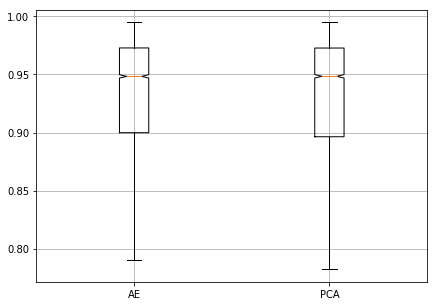

In [21]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.216543984640463
AE 3.2061156984061276


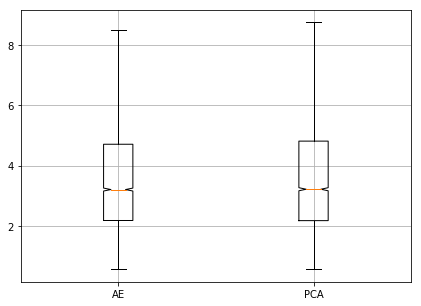

In [22]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Simple Deep

In [23]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_deep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_deep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 50),
                                     activation_layer,
                                     nn.Linear(50, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [24]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_44 = autoencoder_deep(length, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_42 = autoencoder_deep(length, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42 = train_ae(ae_42, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_4_4', np.array(losses_44))
np.save('models/final_models/losses_4_2', np.array(losses_42))


# Saving Models
#torch.save(ae_44, 'models/final_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_42, 'models/final_models/ae_4_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 23775
epoch [1/350000], loss:1690.49255371, avg:1690.49255371
epoch [101/350000], loss:979.76434326, avg:1013.83270264
epoch [201/350000], loss:276.82785034, avg:268.10189819
epoch [301/350000], loss:226.16781616, avg:232.76416016
epoch [401/350000], loss:238.89346313, avg:239.43679810
epoch [501/350000], loss:244.23681641, avg:235.88647461
epoch [601/350000], loss:176.15055847, avg:185.80735779
epoch [701/350000], loss:160.70014954, avg:160.55938721
epoch [801/350000], loss:143.10971069, avg:149.04090881
epoch [901/350000], loss:151.84851074, avg:146.08641052
epoch [1001/350000], loss:136.03233337, avg:144.66294861
epoch [1101/350000], loss:133.55081177, avg:142.22404480
epoch [1201/350000], loss:132.21864319, avg:141.00775146
epoch [1301/350000], loss:134.28921509, avg:142.46478271
epoch [1401/350000], loss:132.14836121, avg:139.75566101
epoch [1501/350000], loss:136.36566162, avg:136.22204590
epoch [1601/350000], loss:137.81050110, avg:139.93190002
epoch 

epoch [14301/350000], loss:126.52326965, avg:129.35768127
epoch [14401/350000], loss:127.34204102, avg:127.43668365
epoch [14501/350000], loss:128.80134583, avg:131.36488342
epoch [14601/350000], loss:123.42898560, avg:128.71302795
epoch [14701/350000], loss:127.89353943, avg:127.57301331
epoch [14801/350000], loss:125.83628845, avg:128.03938293
epoch [14901/350000], loss:124.45713806, avg:127.05603027
epoch [15001/350000], loss:131.83876038, avg:124.70379639
epoch [15101/350000], loss:138.03201294, avg:128.58775330
epoch [15201/350000], loss:124.27964020, avg:129.37716675
epoch [15301/350000], loss:126.79207611, avg:129.33364868
epoch [15401/350000], loss:132.21891785, avg:125.93463135
epoch [15501/350000], loss:121.60030365, avg:127.01737213
epoch [15601/350000], loss:123.44136810, avg:125.48155975
epoch [15701/350000], loss:126.29764557, avg:129.02445984
epoch [15801/350000], loss:129.96960449, avg:126.25514221
epoch [15901/350000], loss:125.24311829, avg:129.63269043
epoch [16001/3

epoch [28501/350000], loss:132.88589478, avg:124.89939117
epoch [28601/350000], loss:125.77612305, avg:124.34329987
epoch [28701/350000], loss:124.88870239, avg:125.08896637
epoch [28801/350000], loss:130.00274658, avg:123.24553680
epoch [28901/350000], loss:129.11976624, avg:123.17030334
epoch [29001/350000], loss:131.31588745, avg:125.54341888
epoch [29101/350000], loss:114.49603271, avg:123.27797699
epoch [29201/350000], loss:124.19429779, avg:125.50048065
epoch [29301/350000], loss:120.88745117, avg:126.11885071
epoch [29401/350000], loss:129.83067322, avg:126.96866608
epoch [29501/350000], loss:125.78237152, avg:122.77269745
epoch [29601/350000], loss:131.21807861, avg:124.50640106
epoch [29701/350000], loss:126.89884949, avg:126.39306641
epoch [29801/350000], loss:118.58494568, avg:127.01822662
epoch [29901/350000], loss:120.96163940, avg:123.32784271
epoch [30001/350000], loss:122.86550140, avg:126.38294983
epoch [30101/350000], loss:122.55555725, avg:125.48628998
epoch [30201/3

epoch [42701/350000], loss:125.67945862, avg:122.56063080
epoch [42801/350000], loss:118.30833435, avg:121.46382904
epoch [42901/350000], loss:118.23342896, avg:121.11531067
epoch [43001/350000], loss:127.71366119, avg:122.61384583
epoch [43101/350000], loss:122.94488525, avg:123.04138184
epoch [43201/350000], loss:121.22240448, avg:120.54341888
epoch [43301/350000], loss:121.99588013, avg:120.56011200
epoch [43401/350000], loss:124.05290985, avg:119.56856537
epoch [43501/350000], loss:122.23548126, avg:121.57176971
epoch [43601/350000], loss:128.91726685, avg:122.96706390
epoch [43701/350000], loss:125.17915344, avg:122.28708649
epoch [43801/350000], loss:118.20108032, avg:118.78199768
epoch [43901/350000], loss:124.76029205, avg:122.06877899
epoch [44001/350000], loss:118.69906616, avg:119.00591278
epoch [44101/350000], loss:121.47257996, avg:121.06206512
epoch [44201/350000], loss:119.93948364, avg:118.32260895
epoch [44301/350000], loss:116.90343475, avg:120.80460358
epoch [44401/3

epoch [56901/350000], loss:117.30883789, avg:119.47912598
epoch [57001/350000], loss:117.77944946, avg:120.76556396
epoch [57101/350000], loss:118.90057373, avg:118.04074860
epoch [57201/350000], loss:126.91065216, avg:117.07712555
epoch [57301/350000], loss:126.03617859, avg:119.43957520
epoch [57401/350000], loss:114.44472504, avg:117.30339813
epoch [57501/350000], loss:114.15139008, avg:118.86042786
epoch [57601/350000], loss:122.05138397, avg:118.32160950
epoch [57701/350000], loss:119.22345734, avg:117.74956512
epoch [57801/350000], loss:112.87128448, avg:119.32026672
epoch [57901/350000], loss:112.22280121, avg:118.74979401
epoch [58001/350000], loss:123.32762909, avg:121.10263824
epoch [58101/350000], loss:116.54206085, avg:117.85582733
epoch [58201/350000], loss:122.50238037, avg:118.00197601
epoch [58301/350000], loss:124.89859772, avg:120.87224579
epoch [58401/350000], loss:128.52461243, avg:121.35219574
epoch [58501/350000], loss:116.38437653, avg:118.22796631
epoch [58601/3

epoch [71101/350000], loss:114.19648743, avg:111.74983978
epoch [71201/350000], loss:112.37956238, avg:112.71406555
epoch [71301/350000], loss:112.09432983, avg:114.40811920
epoch [71401/350000], loss:119.71556854, avg:113.85406494
epoch [71501/350000], loss:109.87910461, avg:111.84262848
epoch [71601/350000], loss:108.59384918, avg:115.36976624
epoch [71701/350000], loss:113.40045166, avg:112.03200531
epoch [71801/350000], loss:109.47743988, avg:112.47373199
epoch [71901/350000], loss:116.69451904, avg:112.29597473
epoch [72001/350000], loss:119.16328430, avg:111.81351471
epoch [72101/350000], loss:112.31988525, avg:112.10707855
epoch [72201/350000], loss:117.15890503, avg:113.05971527
epoch [72301/350000], loss:110.24961090, avg:112.23447418
epoch [72401/350000], loss:123.34947968, avg:113.04293060
epoch [72501/350000], loss:115.54667664, avg:112.23697662
epoch [72601/350000], loss:112.64505005, avg:112.09191132
epoch [72701/350000], loss:112.38082886, avg:111.89302063
epoch [72801/3

epoch [85301/350000], loss:117.74042511, avg:107.11661530
epoch [85401/350000], loss:105.93170929, avg:108.62597656
epoch [85501/350000], loss:113.24746704, avg:108.08819580
epoch [85601/350000], loss:113.19544220, avg:108.35711670
epoch [85701/350000], loss:110.02325439, avg:104.21577454
epoch [85801/350000], loss:114.52470398, avg:107.43145752
epoch [85901/350000], loss:102.78675842, avg:108.27288055
epoch [86001/350000], loss:103.47409821, avg:105.44741058
epoch [86101/350000], loss:118.70014954, avg:108.44396210
epoch [86201/350000], loss:105.81165314, avg:110.09983063
epoch [86301/350000], loss:109.24240112, avg:106.02358246
epoch [86401/350000], loss:107.96230316, avg:107.48876190
epoch [86501/350000], loss:102.88314056, avg:108.55024719
epoch [86601/350000], loss:105.74843597, avg:109.17844391
epoch [86701/350000], loss:105.85892487, avg:106.58161926
epoch [86801/350000], loss:111.47233582, avg:108.39876556
epoch [86901/350000], loss:109.03348541, avg:108.06671143
epoch [87001/3

epoch [99501/350000], loss:104.05385590, avg:104.73241425
epoch [99601/350000], loss:99.37364197, avg:105.39115143
epoch [99701/350000], loss:104.42421722, avg:105.41574860
epoch [99801/350000], loss:112.59877014, avg:105.81722260
epoch [99901/350000], loss:98.67452240, avg:105.20765686
epoch [100001/350000], loss:103.13341522, avg:105.39302063
epoch [100101/350000], loss:104.55257416, avg:107.82811737
epoch [100201/350000], loss:108.48930359, avg:104.77129364
epoch [100301/350000], loss:116.61334991, avg:105.20232391
epoch [100401/350000], loss:104.01673126, avg:104.28958893
epoch [100501/350000], loss:105.70633698, avg:103.21231842
epoch [100601/350000], loss:102.53727722, avg:104.58158112
epoch [100701/350000], loss:102.73844910, avg:106.76963043
epoch [100801/350000], loss:103.54801941, avg:107.33985901
epoch [100901/350000], loss:104.84926605, avg:105.01843262
epoch [101001/350000], loss:102.09099579, avg:104.57999420
epoch [101101/350000], loss:98.74885559, avg:105.42844391
epoch

epoch [113501/350000], loss:109.34792328, avg:106.85711670
epoch [113601/350000], loss:103.58614349, avg:106.73192596
epoch [113701/350000], loss:103.57250977, avg:104.42968750
epoch [113801/350000], loss:112.84378052, avg:109.35772705
epoch [113901/350000], loss:104.29225159, avg:104.56548309
epoch [114001/350000], loss:104.74088287, avg:105.84653473
epoch [114101/350000], loss:112.23165131, avg:105.80755615
epoch [114201/350000], loss:97.97937775, avg:103.84604645
epoch [114301/350000], loss:104.62210846, avg:104.81237793
epoch [114401/350000], loss:106.40474701, avg:108.06699371
epoch [114501/350000], loss:101.48898315, avg:104.28558350
epoch [114601/350000], loss:106.57817841, avg:102.95781708
epoch [114701/350000], loss:107.51701355, avg:106.18151855
epoch [114801/350000], loss:104.24130249, avg:105.57283783
epoch [114901/350000], loss:106.71861267, avg:105.47015381
epoch [115001/350000], loss:99.12252808, avg:104.32745361
epoch [115101/350000], loss:105.42689514, avg:104.71931458

epoch [127501/350000], loss:106.53486633, avg:106.29863739
epoch [127601/350000], loss:104.15979004, avg:103.75542450
epoch [127701/350000], loss:102.04541016, avg:102.99853516
epoch [127801/350000], loss:101.52653503, avg:103.63120270
epoch [127901/350000], loss:104.79591370, avg:103.75624084
epoch [128001/350000], loss:104.16757965, avg:106.01462555
epoch [128101/350000], loss:100.90135956, avg:101.83171844
epoch [128201/350000], loss:100.55061340, avg:104.67368317
epoch [128301/350000], loss:107.10570526, avg:105.19343567
epoch [128401/350000], loss:106.77095032, avg:103.61653137
epoch [128501/350000], loss:104.19870758, avg:104.34808350
epoch [128601/350000], loss:102.53871918, avg:104.20848846
epoch [128701/350000], loss:100.48500061, avg:105.26250458
epoch [128801/350000], loss:102.97914886, avg:102.97291565
epoch [128901/350000], loss:99.98300934, avg:103.65465546
epoch [129001/350000], loss:112.32044220, avg:102.84809875
epoch [129101/350000], loss:101.36302185, avg:102.0384674

epoch [141501/350000], loss:104.67582703, avg:105.21900940
epoch [141601/350000], loss:103.64784241, avg:103.46895599
epoch [141701/350000], loss:104.62408447, avg:102.25977325
epoch [141801/350000], loss:106.17075348, avg:103.04605865
epoch [141901/350000], loss:104.17562866, avg:102.28387451
epoch [142001/350000], loss:104.78186035, avg:104.51206207
epoch [142101/350000], loss:103.60105896, avg:103.94223785
epoch [142201/350000], loss:103.54454041, avg:102.99153137
epoch [142301/350000], loss:106.60658264, avg:101.70253754
epoch [142401/350000], loss:108.91004944, avg:104.25825500
epoch [142501/350000], loss:104.85479736, avg:103.09189606
epoch [142601/350000], loss:102.43661499, avg:102.90195465
epoch [142701/350000], loss:107.54356384, avg:103.27003479
epoch [142801/350000], loss:98.45647430, avg:102.78505707
epoch [142901/350000], loss:103.34243774, avg:103.00402832
epoch [143001/350000], loss:104.76341248, avg:104.19496155
epoch [143101/350000], loss:112.74838257, avg:102.8764038

epoch [155501/350000], loss:102.46273804, avg:103.31804657
epoch [155601/350000], loss:104.54175568, avg:100.70738983
epoch [155701/350000], loss:106.95343018, avg:103.16106415
epoch [155801/350000], loss:105.66201019, avg:104.10186005
epoch [155901/350000], loss:103.44937897, avg:102.49745178
epoch [156001/350000], loss:102.85331726, avg:102.48384857
epoch [156101/350000], loss:103.20083618, avg:101.86742401
epoch [156201/350000], loss:99.15071869, avg:102.15302277
epoch [156301/350000], loss:99.23825073, avg:104.30632782
epoch [156401/350000], loss:103.42381287, avg:103.09539795
epoch [156501/350000], loss:105.77996826, avg:104.95855713
epoch [156601/350000], loss:104.10791779, avg:101.77835846
epoch [156701/350000], loss:105.42085266, avg:102.96096039
epoch [156801/350000], loss:106.07447052, avg:102.36687469
epoch [156901/350000], loss:105.01641083, avg:100.02016449
epoch [157001/350000], loss:100.29840088, avg:102.67742157
epoch [157101/350000], loss:98.97418976, avg:103.71166229


epoch [169501/350000], loss:104.24653625, avg:104.42852020
epoch [169601/350000], loss:103.84638977, avg:105.20926666
epoch [169701/350000], loss:101.54589081, avg:104.97650146
epoch [169801/350000], loss:105.82757568, avg:104.84819794
epoch [169901/350000], loss:99.54679871, avg:103.73912811
epoch [170001/350000], loss:99.95901489, avg:103.58121490
epoch [170101/350000], loss:106.48066711, avg:105.06005859
epoch [170201/350000], loss:106.79772949, avg:102.95699310
epoch [170301/350000], loss:103.61946869, avg:103.92600250
epoch [170401/350000], loss:96.79385376, avg:100.42000580
epoch [170501/350000], loss:96.79338074, avg:100.81514740
epoch [170601/350000], loss:102.22109985, avg:101.02882385
epoch [170701/350000], loss:106.40512848, avg:102.43221283
epoch [170801/350000], loss:100.03176117, avg:103.75901031
epoch [170901/350000], loss:107.12889099, avg:104.64858246
epoch [171001/350000], loss:100.64151764, avg:103.30496979
epoch [171101/350000], loss:102.84982300, avg:102.39865875
e

epoch [183501/350000], loss:104.88188171, avg:104.48293304
epoch [183601/350000], loss:107.98342133, avg:102.47380829
epoch [183701/350000], loss:99.39906311, avg:101.54833221
epoch [183801/350000], loss:102.40154266, avg:103.46984100
epoch [183901/350000], loss:99.82586670, avg:102.86523438
epoch [184001/350000], loss:102.26975250, avg:104.45986176
epoch [184101/350000], loss:104.56129456, avg:102.80908203
epoch [184201/350000], loss:105.78321838, avg:102.15126801
epoch [184301/350000], loss:103.44036102, avg:101.46635437
epoch [184401/350000], loss:101.95743561, avg:99.88088226
epoch [184501/350000], loss:103.19187164, avg:101.32341766
epoch [184601/350000], loss:101.87882233, avg:102.60709381
epoch [184701/350000], loss:106.22586823, avg:103.09941864
epoch [184801/350000], loss:100.60715485, avg:101.99843597
epoch [184901/350000], loss:99.12912750, avg:101.93849945
epoch [185001/350000], loss:99.72689819, avg:103.00460052
epoch [185101/350000], loss:104.51965332, avg:103.70438385
ep

epoch [197501/350000], loss:109.22728729, avg:102.91578674
epoch [197601/350000], loss:107.30196381, avg:104.90686035
epoch [197701/350000], loss:100.39861298, avg:103.16558075
epoch [197801/350000], loss:105.83079529, avg:103.23207092
epoch [197901/350000], loss:101.13695526, avg:101.64092255
epoch [198001/350000], loss:102.86061859, avg:103.29754639
epoch [198101/350000], loss:99.76611328, avg:101.35339355
epoch [198201/350000], loss:104.15173340, avg:103.65258789
epoch [198301/350000], loss:98.86476898, avg:103.11034393
epoch [198401/350000], loss:103.58266449, avg:106.33668518
epoch [198501/350000], loss:100.17451477, avg:103.23164368
epoch [198601/350000], loss:106.32550812, avg:103.74891663
epoch [198701/350000], loss:101.02863312, avg:102.23238373
epoch [198801/350000], loss:100.22256470, avg:103.69498444
epoch [198901/350000], loss:104.23804474, avg:104.92071533
epoch [199001/350000], loss:102.47687531, avg:102.94032288
epoch [199101/350000], loss:102.11431122, avg:103.18044281

epoch [211501/350000], loss:106.48116302, avg:103.77626801
epoch [211601/350000], loss:99.51074219, avg:103.31855774
epoch [211701/350000], loss:104.13972473, avg:101.91523743
epoch [211801/350000], loss:105.02999878, avg:103.31026459
epoch [211901/350000], loss:110.95167542, avg:104.64354706
epoch [212001/350000], loss:98.32351685, avg:100.70879364
epoch [212101/350000], loss:100.29187775, avg:103.13686371
epoch [212201/350000], loss:99.73472595, avg:104.10101318
epoch [212301/350000], loss:101.35473633, avg:103.05505371
epoch [212401/350000], loss:101.48557281, avg:102.76312256
epoch [212501/350000], loss:110.39838409, avg:103.00086975
epoch [212601/350000], loss:98.20875549, avg:101.59261322
epoch [212701/350000], loss:102.98961639, avg:102.22680664
epoch [212801/350000], loss:98.44632721, avg:100.86211395
epoch [212901/350000], loss:101.37673187, avg:101.78121948
epoch [213001/350000], loss:107.17079926, avg:101.20780182
epoch [213101/350000], loss:99.52565002, avg:101.64379883
epo

epoch [225501/350000], loss:104.48951721, avg:101.43337250
epoch [225601/350000], loss:100.28383636, avg:100.26961517
epoch [225701/350000], loss:100.62622833, avg:103.15956879
epoch [225801/350000], loss:107.87415314, avg:102.02770233
epoch [225901/350000], loss:103.17669678, avg:100.79897308
epoch [226001/350000], loss:101.84643555, avg:100.81178284
epoch [226101/350000], loss:100.94585419, avg:102.46599579
epoch [226201/350000], loss:106.67008209, avg:103.87377167
epoch [226301/350000], loss:100.56473541, avg:103.30477142
epoch [226401/350000], loss:108.10276794, avg:102.59201813
epoch [226501/350000], loss:100.80973053, avg:101.56163025
epoch [226601/350000], loss:102.84661102, avg:102.69878387
epoch [226701/350000], loss:102.65252686, avg:100.75688171
epoch [226801/350000], loss:101.65879059, avg:103.51171112
epoch [226901/350000], loss:100.05577087, avg:101.90536499
epoch [227001/350000], loss:103.49518585, avg:103.46364594
epoch [227101/350000], loss:97.99285889, avg:100.4890136

epoch [239501/350000], loss:105.04869843, avg:102.45960999
epoch [239601/350000], loss:100.06343842, avg:101.38911438
epoch [239701/350000], loss:100.69808960, avg:104.54931641
epoch [239801/350000], loss:101.12794495, avg:102.00584412
epoch [239901/350000], loss:106.50264740, avg:101.58151245
epoch [240001/350000], loss:99.60973358, avg:99.93820953
epoch [240101/350000], loss:101.01708984, avg:102.24002075
epoch [240201/350000], loss:98.53701019, avg:98.57954407
epoch [240301/350000], loss:99.75005341, avg:100.99623108
epoch [240401/350000], loss:104.70458984, avg:100.92824554
epoch [240501/350000], loss:101.90391541, avg:102.58365631
epoch [240601/350000], loss:102.23872375, avg:100.66838837
epoch [240701/350000], loss:103.73960876, avg:103.40911102
epoch [240801/350000], loss:105.73274231, avg:103.10637665
epoch [240901/350000], loss:105.58537292, avg:101.65453339
epoch [241001/350000], loss:102.40654755, avg:102.11660767
epoch [241101/350000], loss:104.84791565, avg:102.09414673
ep

epoch [253501/350000], loss:110.30156708, avg:102.78697968
epoch [253601/350000], loss:101.29615021, avg:103.96920013
epoch [253701/350000], loss:102.70953369, avg:102.50347900
epoch [253801/350000], loss:105.01519012, avg:103.55836487
epoch [253901/350000], loss:94.51833344, avg:101.37812805
epoch [254001/350000], loss:96.83797455, avg:101.93158722
epoch [254101/350000], loss:101.20774841, avg:101.71755219
epoch [254201/350000], loss:102.34159851, avg:102.29538727
epoch [254301/350000], loss:106.35998535, avg:101.78656769
epoch [254401/350000], loss:97.16896820, avg:100.16649628
epoch [254501/350000], loss:101.59909821, avg:102.81359100
epoch [254601/350000], loss:100.95214081, avg:101.59573364
epoch [254701/350000], loss:96.23641968, avg:101.66387177
epoch [254801/350000], loss:99.40812683, avg:100.57247925
epoch [254901/350000], loss:106.50350952, avg:101.38336182
epoch [255001/350000], loss:99.50572968, avg:101.83512115
epoch [255101/350000], loss:106.63676453, avg:101.16310883
epo

epoch [267501/350000], loss:102.24644470, avg:103.29741669
epoch [267601/350000], loss:105.04693604, avg:103.61833954
epoch [267701/350000], loss:100.29151154, avg:99.97418213
epoch [267801/350000], loss:98.68444824, avg:99.22753906
epoch [267901/350000], loss:111.16697693, avg:101.24176788
epoch [268001/350000], loss:102.36243439, avg:102.82153320
epoch [268101/350000], loss:107.32810974, avg:100.44709015
epoch [268201/350000], loss:99.84841156, avg:99.90627289
epoch [268301/350000], loss:99.91998291, avg:103.04017639
epoch [268401/350000], loss:97.59378815, avg:101.98312378
epoch [268501/350000], loss:100.94431305, avg:104.41345215
epoch [268601/350000], loss:101.32274628, avg:100.84088135
epoch [268701/350000], loss:107.93320465, avg:100.21672821
epoch [268801/350000], loss:100.86088562, avg:99.21180725
epoch [268901/350000], loss:95.06594849, avg:102.59812164
epoch [269001/350000], loss:101.83558655, avg:100.73893738
epoch [269101/350000], loss:96.79786682, avg:100.39858246
epoch [

epoch [281501/350000], loss:106.91439056, avg:102.58874512
epoch [281601/350000], loss:99.72027588, avg:101.81327820
epoch [281701/350000], loss:104.02776337, avg:102.07405853
epoch [281801/350000], loss:103.07351685, avg:103.96343994
epoch [281901/350000], loss:99.81593323, avg:101.05733490
epoch [282001/350000], loss:100.96584320, avg:101.97894287
epoch [282101/350000], loss:97.15651703, avg:102.57454681
epoch [282201/350000], loss:93.72885132, avg:101.34010315
epoch [282301/350000], loss:98.59831238, avg:101.58962250
epoch [282401/350000], loss:107.11991882, avg:103.80517578
epoch [282501/350000], loss:96.15262604, avg:101.00914001
epoch [282601/350000], loss:106.28725433, avg:102.50874329
epoch [282701/350000], loss:96.55278778, avg:100.42807770
epoch [282801/350000], loss:102.12179565, avg:100.43798828
epoch [282901/350000], loss:100.30139160, avg:100.74285126
epoch [283001/350000], loss:99.66009521, avg:99.65935516
epoch [283101/350000], loss:105.81568909, avg:102.33646393
epoch 

epoch [295501/350000], loss:99.13832855, avg:102.94347382
epoch [295601/350000], loss:100.32033539, avg:102.46878815
epoch [295701/350000], loss:106.20362854, avg:101.85649109
epoch [295801/350000], loss:99.11309052, avg:100.52033997
epoch [295901/350000], loss:97.15395355, avg:100.91046906
epoch [296001/350000], loss:101.57933044, avg:100.11704254
epoch [296101/350000], loss:102.32888794, avg:100.75804901
epoch [296201/350000], loss:96.89570618, avg:99.92814636
epoch [296301/350000], loss:101.44102478, avg:100.63567352
epoch [296401/350000], loss:96.23220825, avg:98.97838593
epoch [296501/350000], loss:101.91423035, avg:101.45126343
epoch [296601/350000], loss:102.79453278, avg:100.49821472
epoch [296701/350000], loss:100.60382080, avg:102.81633759
epoch [296801/350000], loss:100.94891357, avg:101.92877197
epoch [296901/350000], loss:98.60858154, avg:100.40576172
epoch [297001/350000], loss:97.34098053, avg:100.19881439
epoch [297101/350000], loss:99.41354370, avg:101.14869690
epoch [

epoch [309601/350000], loss:96.44541168, avg:101.39351654
epoch [309701/350000], loss:100.28546906, avg:100.34976959
epoch [309801/350000], loss:98.87581635, avg:102.46087646
epoch [309901/350000], loss:109.93976593, avg:100.41646576
epoch [310001/350000], loss:96.26645660, avg:101.28412628
epoch [310101/350000], loss:106.16182709, avg:102.34165955
epoch [310201/350000], loss:98.65715790, avg:100.70305634
epoch [310301/350000], loss:101.67961121, avg:99.98712158
epoch [310401/350000], loss:103.89585114, avg:101.57473755
epoch [310501/350000], loss:101.91474152, avg:102.48797607
epoch [310601/350000], loss:99.91780853, avg:102.49964905
epoch [310701/350000], loss:98.68793488, avg:102.11240387
epoch [310801/350000], loss:104.91965485, avg:102.58516693
epoch [310901/350000], loss:105.68640900, avg:102.39344788
epoch [311001/350000], loss:100.36172485, avg:100.98992920
epoch [311101/350000], loss:99.03732300, avg:100.03755951
epoch [311201/350000], loss:101.21161652, avg:102.05448151
epoch

epoch [323701/350000], loss:102.76399994, avg:101.23452759
epoch [323801/350000], loss:100.99369812, avg:101.14421844
epoch [323901/350000], loss:96.65957642, avg:100.79443359
epoch [324001/350000], loss:101.51335144, avg:100.25618744
epoch [324101/350000], loss:110.65216064, avg:100.97717285
epoch [324201/350000], loss:101.24028015, avg:100.58328247
epoch [324301/350000], loss:103.76567078, avg:101.86577606
epoch [324401/350000], loss:101.19267273, avg:100.48818207
epoch [324501/350000], loss:100.34375763, avg:100.93636322
epoch [324601/350000], loss:98.76902008, avg:102.47774506
epoch [324701/350000], loss:103.27141571, avg:101.17318726
epoch [324801/350000], loss:99.35155487, avg:101.52066803
epoch [324901/350000], loss:98.66684723, avg:101.08019257
epoch [325001/350000], loss:99.51779175, avg:102.16487885
epoch [325101/350000], loss:101.06202698, avg:101.96320343
epoch [325201/350000], loss:99.31975555, avg:101.84528351
epoch [325301/350000], loss:94.85452271, avg:102.28443909
epoc

epoch [337701/350000], loss:98.30193329, avg:100.60122681
epoch [337801/350000], loss:101.85887146, avg:102.39386749
epoch [337901/350000], loss:101.97592926, avg:101.18616486
epoch [338001/350000], loss:101.92731476, avg:101.79918671
epoch [338101/350000], loss:104.22396851, avg:101.65641022
epoch [338201/350000], loss:101.50237274, avg:101.05560303
epoch [338301/350000], loss:101.28401947, avg:102.15173340
epoch [338401/350000], loss:97.36287689, avg:101.77600861
epoch [338501/350000], loss:97.24349976, avg:100.86968231
epoch [338601/350000], loss:108.11174011, avg:100.32672882
epoch [338701/350000], loss:101.80077362, avg:102.31867218
epoch [338801/350000], loss:104.69667816, avg:101.08367920
epoch [338901/350000], loss:102.89376068, avg:104.01856995
epoch [339001/350000], loss:105.04303741, avg:103.08695221
epoch [339101/350000], loss:104.79705048, avg:103.18743896
epoch [339201/350000], loss:97.59869385, avg:101.01461029
epoch [339301/350000], loss:102.53337097, avg:101.93202972
e

In [25]:
ae_1 = torch.load('models/final_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.959586963260389
PCA 0.9483949747235523


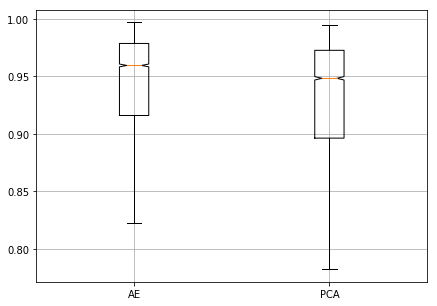

In [26]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.216543984640561
AE 2.8106700048423914


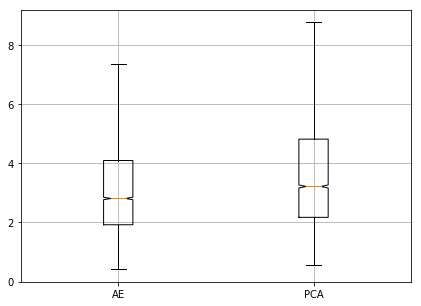

In [27]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Deep Encoder - Shallow Decoder Variation

In [28]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_var(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_var, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 10),
                                     activation_layer,
                                     nn.Linear(10, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [29]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_var(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_var(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52 = train_ae(ae_52, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_5_4', np.array(losses_54))
np.save('models/final_models/losses_5_2', np.array(losses_52))


# Saving Models
#torch.save(ae_54, 'models/final_models/ae_5_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/final_models/ae_5_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 18613
epoch [1/350000], loss:1591.29443359, avg:1591.29443359
epoch [101/350000], loss:1437.98901367, avg:1430.46228027
epoch [201/350000], loss:542.30279541, avg:572.00286865
epoch [301/350000], loss:276.06658936, avg:278.40106201
epoch [401/350000], loss:223.20216370, avg:236.75227356
epoch [501/350000], loss:203.33430481, avg:211.78408813
epoch [601/350000], loss:168.95014954, avg:178.62736511
epoch [701/350000], loss:153.22933960, avg:158.21951294
epoch [801/350000], loss:166.83119202, avg:151.12565613
epoch [901/350000], loss:142.17373657, avg:140.00067139
epoch [1001/350000], loss:135.29850769, avg:140.57421875
epoch [1101/350000], loss:150.46243286, avg:143.44374084
epoch [1201/350000], loss:128.66444397, avg:143.05711365
epoch [1301/350000], loss:141.74235535, avg:140.28930664
epoch [1401/350000], loss:146.40367126, avg:144.33262634
epoch [1501/350000], loss:140.98307800, avg:140.22906494
epoch [1601/350000], loss:131.46047974, avg:140.73580933
epoch

epoch [14301/350000], loss:112.09468842, avg:119.72167969
epoch [14401/350000], loss:119.48142242, avg:121.79921722
epoch [14501/350000], loss:124.64289093, avg:121.10578918
epoch [14601/350000], loss:134.46337891, avg:126.35988617
epoch [14701/350000], loss:129.06338501, avg:118.27998352
epoch [14801/350000], loss:114.31781769, avg:125.38928223
epoch [14901/350000], loss:127.20825195, avg:125.00764465
epoch [15001/350000], loss:130.44508362, avg:122.13657379
epoch [15101/350000], loss:112.58635712, avg:120.22425842
epoch [15201/350000], loss:121.69029999, avg:120.51564789
epoch [15301/350000], loss:115.33356476, avg:120.59246063
epoch [15401/350000], loss:117.91246796, avg:119.67604065
epoch [15501/350000], loss:123.83602905, avg:124.16489410
epoch [15601/350000], loss:120.17076874, avg:122.03501129
epoch [15701/350000], loss:129.10195923, avg:122.44111633
epoch [15801/350000], loss:116.16871643, avg:121.62755585
epoch [15901/350000], loss:121.31609344, avg:121.68791962
epoch [16001/3

epoch [28501/350000], loss:119.84517670, avg:114.55328369
epoch [28601/350000], loss:122.35544586, avg:116.69140625
epoch [28701/350000], loss:112.49987030, avg:113.08705139
epoch [28801/350000], loss:119.94143677, avg:113.42307281
epoch [28901/350000], loss:111.38375854, avg:113.16772461
epoch [29001/350000], loss:113.50639343, avg:111.95881653
epoch [29101/350000], loss:112.63025665, avg:113.35906982
epoch [29201/350000], loss:112.34474182, avg:113.47285461
epoch [29301/350000], loss:113.93586731, avg:114.95310211
epoch [29401/350000], loss:115.09972382, avg:113.71805573
epoch [29501/350000], loss:120.09623718, avg:113.87564850
epoch [29601/350000], loss:109.13729095, avg:114.71821594
epoch [29701/350000], loss:104.89099884, avg:112.24781799
epoch [29801/350000], loss:104.91954041, avg:114.68769836
epoch [29901/350000], loss:106.37728882, avg:114.03755188
epoch [30001/350000], loss:114.05939484, avg:113.14316559
epoch [30101/350000], loss:113.30210876, avg:113.16053772
epoch [30201/3

epoch [42701/350000], loss:110.20227051, avg:110.92431641
epoch [42801/350000], loss:110.98220825, avg:110.88536835
epoch [42901/350000], loss:103.69695282, avg:112.06947327
epoch [43001/350000], loss:107.57668304, avg:110.85192871
epoch [43101/350000], loss:102.74241638, avg:112.11279297
epoch [43201/350000], loss:122.69248199, avg:111.14974213
epoch [43301/350000], loss:107.22288513, avg:109.35056305
epoch [43401/350000], loss:109.74546814, avg:110.06711578
epoch [43501/350000], loss:107.68256378, avg:109.41059875
epoch [43601/350000], loss:113.09160614, avg:113.12451172
epoch [43701/350000], loss:104.12934875, avg:109.97080231
epoch [43801/350000], loss:109.27766418, avg:108.69323730
epoch [43901/350000], loss:121.09395599, avg:111.70906067
epoch [44001/350000], loss:117.44889069, avg:108.92823792
epoch [44101/350000], loss:106.85602570, avg:108.72292328
epoch [44201/350000], loss:109.63288879, avg:111.40508270
epoch [44301/350000], loss:112.19885254, avg:111.39880371
epoch [44401/3

epoch [56901/350000], loss:112.66965485, avg:107.94750977
epoch [57001/350000], loss:108.23689270, avg:109.88514709
epoch [57101/350000], loss:112.08248138, avg:109.30571747
epoch [57201/350000], loss:110.13652039, avg:109.39617157
epoch [57301/350000], loss:106.99896240, avg:106.14253235
epoch [57401/350000], loss:102.18464661, avg:109.71968079
epoch [57501/350000], loss:115.07343292, avg:108.35301971
epoch [57601/350000], loss:104.78305817, avg:109.43343353
epoch [57701/350000], loss:106.48150635, avg:107.43325043
epoch [57801/350000], loss:113.29452515, avg:109.21089172
epoch [57901/350000], loss:113.50407410, avg:110.95616913
epoch [58001/350000], loss:123.74182892, avg:109.97426605
epoch [58101/350000], loss:111.77578735, avg:108.13614655
epoch [58201/350000], loss:105.66147614, avg:107.87255096
epoch [58301/350000], loss:109.79570770, avg:109.23323822
epoch [58401/350000], loss:103.38120270, avg:108.74743652
epoch [58501/350000], loss:110.52501678, avg:109.29770660
epoch [58601/3

epoch [71101/350000], loss:106.32447052, avg:107.22130585
epoch [71201/350000], loss:103.92343140, avg:108.30785370
epoch [71301/350000], loss:108.58640289, avg:107.09704590
epoch [71401/350000], loss:109.40635681, avg:108.33107758
epoch [71501/350000], loss:108.09617615, avg:105.69667816
epoch [71601/350000], loss:110.55822754, avg:107.00234222
epoch [71701/350000], loss:99.10109711, avg:109.20562744
epoch [71801/350000], loss:107.74903870, avg:107.33742523
epoch [71901/350000], loss:111.81835175, avg:109.31932831
epoch [72001/350000], loss:103.73538971, avg:106.20143127
epoch [72101/350000], loss:109.61289215, avg:105.68775940
epoch [72201/350000], loss:101.68181610, avg:107.28148651
epoch [72301/350000], loss:104.76305389, avg:109.97275543
epoch [72401/350000], loss:108.03153229, avg:107.96891022
epoch [72501/350000], loss:115.52996826, avg:108.33794403
epoch [72601/350000], loss:111.07717133, avg:109.00711823
epoch [72701/350000], loss:105.60190582, avg:107.83312988
epoch [72801/35

epoch [85301/350000], loss:104.51248169, avg:105.69239807
epoch [85401/350000], loss:112.39734650, avg:107.17347717
epoch [85501/350000], loss:107.15362549, avg:107.39916992
epoch [85601/350000], loss:111.60756683, avg:107.86534882
epoch [85701/350000], loss:111.78137207, avg:106.82195282
epoch [85801/350000], loss:106.93330383, avg:105.66078949
epoch [85901/350000], loss:109.62422180, avg:107.21913147
epoch [86001/350000], loss:101.37869263, avg:104.68547821
epoch [86101/350000], loss:105.83456421, avg:105.84777069
epoch [86201/350000], loss:114.36362457, avg:107.59163666
epoch [86301/350000], loss:110.91154480, avg:107.46126556
epoch [86401/350000], loss:105.44451904, avg:108.53163147
epoch [86501/350000], loss:103.71406555, avg:104.45239258
epoch [86601/350000], loss:109.47642517, avg:105.82154846
epoch [86701/350000], loss:111.55525208, avg:107.13683319
epoch [86801/350000], loss:104.70851135, avg:108.14937592
epoch [86901/350000], loss:103.08215332, avg:106.81530762
epoch [87001/3

epoch [99501/350000], loss:106.99507904, avg:107.29565430
epoch [99601/350000], loss:104.50434875, avg:106.81337738
epoch [99701/350000], loss:101.65793610, avg:103.06632233
epoch [99801/350000], loss:103.64047241, avg:106.95442963
epoch [99901/350000], loss:103.84173584, avg:105.10684967
epoch [100001/350000], loss:107.33140564, avg:107.43514252
epoch [100101/350000], loss:101.78582001, avg:104.07409668
epoch [100201/350000], loss:108.26117706, avg:105.73414612
epoch [100301/350000], loss:103.97705841, avg:105.36372375
epoch [100401/350000], loss:103.49729919, avg:106.23375702
epoch [100501/350000], loss:104.98623657, avg:106.40390778
epoch [100601/350000], loss:99.31306458, avg:106.48062897
epoch [100701/350000], loss:104.43316650, avg:105.63481903
epoch [100801/350000], loss:99.40113068, avg:103.55204010
epoch [100901/350000], loss:104.14369202, avg:106.56790924
epoch [101001/350000], loss:100.20215607, avg:107.34728241
epoch [101101/350000], loss:100.33524323, avg:105.65350342
epoc

epoch [113501/350000], loss:105.12497711, avg:103.32036591
epoch [113601/350000], loss:113.35881042, avg:105.04544830
epoch [113701/350000], loss:101.62133026, avg:105.22653961
epoch [113801/350000], loss:108.57009888, avg:106.36688232
epoch [113901/350000], loss:109.74321747, avg:105.69641113
epoch [114001/350000], loss:103.95550537, avg:105.31140137
epoch [114101/350000], loss:104.08287811, avg:106.76009369
epoch [114201/350000], loss:114.47690582, avg:109.17885590
epoch [114301/350000], loss:101.15193939, avg:106.11376190
epoch [114401/350000], loss:99.96810150, avg:106.53797913
epoch [114501/350000], loss:102.01467133, avg:109.22228241
epoch [114601/350000], loss:100.51698303, avg:105.21477509
epoch [114701/350000], loss:108.18579102, avg:107.22499847
epoch [114801/350000], loss:98.70925140, avg:106.68083954
epoch [114901/350000], loss:106.60379028, avg:107.52370453
epoch [115001/350000], loss:117.64048767, avg:106.91729736
epoch [115101/350000], loss:109.45475769, avg:105.65783691

epoch [127501/350000], loss:104.34013367, avg:102.55305481
epoch [127601/350000], loss:102.86190033, avg:103.64253235
epoch [127701/350000], loss:103.02265167, avg:105.93151855
epoch [127801/350000], loss:99.99369049, avg:102.36489105
epoch [127901/350000], loss:100.65210724, avg:104.93678284
epoch [128001/350000], loss:101.98031616, avg:104.80792236
epoch [128101/350000], loss:99.29201508, avg:103.68098450
epoch [128201/350000], loss:113.18647003, avg:105.34175110
epoch [128301/350000], loss:106.54650879, avg:102.93730927
epoch [128401/350000], loss:105.16502380, avg:104.73403168
epoch [128501/350000], loss:103.18651581, avg:104.08345795
epoch [128601/350000], loss:107.55589294, avg:106.52108002
epoch [128701/350000], loss:101.59874725, avg:102.37246704
epoch [128801/350000], loss:105.83338165, avg:103.36816406
epoch [128901/350000], loss:106.46023560, avg:106.50420380
epoch [129001/350000], loss:113.08215332, avg:103.55100250
epoch [129101/350000], loss:107.60210419, avg:104.61290741

epoch [141501/350000], loss:102.87843323, avg:103.88822174
epoch [141601/350000], loss:98.25408173, avg:103.38085175
epoch [141701/350000], loss:110.77925110, avg:104.46245575
epoch [141801/350000], loss:109.02999878, avg:105.20565033
epoch [141901/350000], loss:102.97392273, avg:104.08998108
epoch [142001/350000], loss:102.29650116, avg:103.11583710
epoch [142101/350000], loss:104.32872772, avg:102.93340302
epoch [142201/350000], loss:102.12921906, avg:101.36035919
epoch [142301/350000], loss:109.60156250, avg:104.63616180
epoch [142401/350000], loss:100.30146027, avg:102.65285492
epoch [142501/350000], loss:107.27452850, avg:106.68997955
epoch [142601/350000], loss:102.19967651, avg:103.67598724
epoch [142701/350000], loss:108.86545563, avg:104.92987061
epoch [142801/350000], loss:105.46602631, avg:102.79689789
epoch [142901/350000], loss:102.33644104, avg:102.97212219
epoch [143001/350000], loss:96.93699646, avg:102.99116516
epoch [143101/350000], loss:102.12931824, avg:104.18145752

epoch [155501/350000], loss:104.56311035, avg:103.72946930
epoch [155601/350000], loss:106.36826324, avg:102.36714935
epoch [155701/350000], loss:107.17860413, avg:106.28554535
epoch [155801/350000], loss:100.93724060, avg:101.18344879
epoch [155901/350000], loss:105.20513153, avg:103.66745758
epoch [156001/350000], loss:99.55699158, avg:102.78106689
epoch [156101/350000], loss:108.50425720, avg:104.36437988
epoch [156201/350000], loss:109.46576691, avg:104.28765106
epoch [156301/350000], loss:107.26847839, avg:104.74613190
epoch [156401/350000], loss:103.06062317, avg:104.07027435
epoch [156501/350000], loss:101.71506500, avg:105.37950897
epoch [156601/350000], loss:105.56517792, avg:107.68888092
epoch [156701/350000], loss:104.25318909, avg:104.46823883
epoch [156801/350000], loss:111.41465759, avg:106.07460022
epoch [156901/350000], loss:106.87869263, avg:107.12719727
epoch [157001/350000], loss:105.10907745, avg:104.68237305
epoch [157101/350000], loss:99.08264160, avg:103.18296051

epoch [169501/350000], loss:102.70521545, avg:104.19866180
epoch [169601/350000], loss:96.12893677, avg:101.99971008
epoch [169701/350000], loss:102.00535583, avg:103.35083008
epoch [169801/350000], loss:99.28392792, avg:104.52188873
epoch [169901/350000], loss:99.61277771, avg:106.38188934
epoch [170001/350000], loss:100.96272278, avg:103.74456024
epoch [170101/350000], loss:102.75589752, avg:103.82604980
epoch [170201/350000], loss:105.14911652, avg:104.48516083
epoch [170301/350000], loss:105.40177917, avg:102.03307343
epoch [170401/350000], loss:107.51299286, avg:103.43733215
epoch [170501/350000], loss:98.00786591, avg:102.18764496
epoch [170601/350000], loss:103.30088043, avg:104.31649017
epoch [170701/350000], loss:102.20178986, avg:104.92372894
epoch [170801/350000], loss:103.22552490, avg:103.19329834
epoch [170901/350000], loss:99.77227783, avg:102.14027405
epoch [171001/350000], loss:103.09006500, avg:104.93922424
epoch [171101/350000], loss:105.32402802, avg:106.29225159
ep

epoch [183501/350000], loss:104.10565186, avg:103.45891571
epoch [183601/350000], loss:101.39086914, avg:103.01157379
epoch [183701/350000], loss:102.91304016, avg:105.19439697
epoch [183801/350000], loss:106.75856781, avg:103.57897949
epoch [183901/350000], loss:100.92738342, avg:105.25341797
epoch [184001/350000], loss:111.44704437, avg:104.48939514
epoch [184101/350000], loss:100.18975830, avg:105.15203094
epoch [184201/350000], loss:103.58967590, avg:101.48079681
epoch [184301/350000], loss:106.43439484, avg:103.00911713
epoch [184401/350000], loss:99.20651245, avg:102.03475189
epoch [184501/350000], loss:103.45175171, avg:104.36267090
epoch [184601/350000], loss:107.69603729, avg:102.22782898
epoch [184701/350000], loss:95.83917999, avg:103.23451233
epoch [184801/350000], loss:105.87547302, avg:103.09123993
epoch [184901/350000], loss:96.31919098, avg:103.51171112
epoch [185001/350000], loss:100.10665131, avg:104.78729248
epoch [185101/350000], loss:104.06784058, avg:105.31298828


epoch [197501/350000], loss:107.00447845, avg:104.56565094
epoch [197601/350000], loss:107.40513611, avg:105.23128510
epoch [197701/350000], loss:102.51186371, avg:105.39739990
epoch [197801/350000], loss:104.54478455, avg:102.32270050
epoch [197901/350000], loss:103.23005676, avg:107.46260834
epoch [198001/350000], loss:106.49263000, avg:108.10455322
epoch [198101/350000], loss:104.47754669, avg:104.87252045
epoch [198201/350000], loss:114.06250000, avg:106.00329590
epoch [198301/350000], loss:101.62072754, avg:105.54791260
epoch [198401/350000], loss:104.56185913, avg:104.90633392
epoch [198501/350000], loss:103.26818848, avg:105.88507080
epoch [198601/350000], loss:99.53913116, avg:104.16390228
epoch [198701/350000], loss:105.49019623, avg:104.24975586
epoch [198801/350000], loss:98.60596466, avg:104.78615570
epoch [198901/350000], loss:102.69824982, avg:102.81097412
epoch [199001/350000], loss:101.49192047, avg:105.58408356
epoch [199101/350000], loss:101.68439484, avg:101.82430267

epoch [211501/350000], loss:94.56160736, avg:103.84708405
epoch [211601/350000], loss:97.22287750, avg:104.03328705
epoch [211701/350000], loss:108.70295715, avg:102.85875702
epoch [211801/350000], loss:106.64509583, avg:104.86926270
epoch [211901/350000], loss:103.35018158, avg:104.68230438
epoch [212001/350000], loss:107.40465546, avg:105.68782806
epoch [212101/350000], loss:105.72497559, avg:103.97084045
epoch [212201/350000], loss:108.78046417, avg:105.50923920
epoch [212301/350000], loss:103.86130524, avg:104.53090668
epoch [212401/350000], loss:108.67945862, avg:108.40482330
epoch [212501/350000], loss:102.97867584, avg:103.93836975
epoch [212601/350000], loss:108.00579834, avg:106.45305634
epoch [212701/350000], loss:102.03263855, avg:106.60377502
epoch [212801/350000], loss:102.77352905, avg:107.52861786
epoch [212901/350000], loss:111.56412506, avg:105.53932953
epoch [213001/350000], loss:96.69509888, avg:103.75310516
epoch [213101/350000], loss:106.65860748, avg:106.43094635


epoch [225501/350000], loss:101.38928223, avg:105.84516907
epoch [225601/350000], loss:103.80743408, avg:105.54671478
epoch [225701/350000], loss:104.90449524, avg:104.63393402
epoch [225801/350000], loss:104.25362396, avg:103.98970032
epoch [225901/350000], loss:101.38295746, avg:101.86706543
epoch [226001/350000], loss:105.86594391, avg:102.85692596
epoch [226101/350000], loss:102.62919617, avg:105.39748383
epoch [226201/350000], loss:105.07370758, avg:106.32242584
epoch [226301/350000], loss:99.06348419, avg:103.80777740
epoch [226401/350000], loss:106.69306183, avg:102.89605713
epoch [226501/350000], loss:96.59753418, avg:104.91460419
epoch [226601/350000], loss:108.28892517, avg:104.12981415
epoch [226701/350000], loss:107.11366272, avg:105.45690918
epoch [226801/350000], loss:106.10077667, avg:103.27080536
epoch [226901/350000], loss:105.83733368, avg:103.81436920
epoch [227001/350000], loss:100.26388550, avg:101.98382568
epoch [227101/350000], loss:102.41446686, avg:101.47036743

epoch [239501/350000], loss:97.61434937, avg:102.35700989
epoch [239601/350000], loss:106.26840210, avg:103.25447845
epoch [239701/350000], loss:104.47190857, avg:101.30185699
epoch [239801/350000], loss:102.98844147, avg:103.65084076
epoch [239901/350000], loss:101.47756195, avg:102.35753632
epoch [240001/350000], loss:105.33425903, avg:104.33910370
epoch [240101/350000], loss:111.93964386, avg:103.98842621
epoch [240201/350000], loss:103.36376953, avg:102.86943817
epoch [240301/350000], loss:111.34005737, avg:105.35037994
epoch [240401/350000], loss:105.69254303, avg:105.44701385
epoch [240501/350000], loss:96.67770386, avg:105.24688721
epoch [240601/350000], loss:100.66651917, avg:103.51192474
epoch [240701/350000], loss:104.87545776, avg:106.88356781
epoch [240801/350000], loss:103.81454468, avg:102.10430908
epoch [240901/350000], loss:105.16563416, avg:105.22194672
epoch [241001/350000], loss:103.78900909, avg:104.31438446
epoch [241101/350000], loss:103.25305176, avg:103.36923981

epoch [253501/350000], loss:106.25396729, avg:104.14406586
epoch [253601/350000], loss:107.11054230, avg:102.33718872
epoch [253701/350000], loss:102.14344788, avg:104.71550751
epoch [253801/350000], loss:103.49372864, avg:102.82330322
epoch [253901/350000], loss:100.55770874, avg:104.66894531
epoch [254001/350000], loss:99.12902069, avg:101.46279907
epoch [254101/350000], loss:103.11270905, avg:104.51146698
epoch [254201/350000], loss:108.26806641, avg:104.62188721
epoch [254301/350000], loss:98.64513397, avg:104.19472504
epoch [254401/350000], loss:95.96848297, avg:101.05677032
epoch [254501/350000], loss:99.83663177, avg:104.56988525
epoch [254601/350000], loss:103.08078766, avg:102.89208221
epoch [254701/350000], loss:104.61884308, avg:104.22480774
epoch [254801/350000], loss:97.97277832, avg:101.75923157
epoch [254901/350000], loss:108.91643524, avg:103.86855316
epoch [255001/350000], loss:103.97409821, avg:100.73500824
epoch [255101/350000], loss:105.55966949, avg:103.15692139
ep

epoch [267501/350000], loss:102.24341583, avg:103.40350342
epoch [267601/350000], loss:104.27796936, avg:104.08339691
epoch [267701/350000], loss:99.32479858, avg:103.72451019
epoch [267801/350000], loss:105.29292297, avg:105.07640839
epoch [267901/350000], loss:111.58356476, avg:105.40459442
epoch [268001/350000], loss:104.44319153, avg:101.46500397
epoch [268101/350000], loss:106.49390411, avg:102.26461029
epoch [268201/350000], loss:98.39689636, avg:105.10277557
epoch [268301/350000], loss:102.84555054, avg:103.25969696
epoch [268401/350000], loss:104.81666565, avg:104.78798676
epoch [268501/350000], loss:100.76129150, avg:105.47737122
epoch [268601/350000], loss:107.06655884, avg:103.85100555
epoch [268701/350000], loss:103.15107727, avg:103.80450439
epoch [268801/350000], loss:103.07787323, avg:102.13214111
epoch [268901/350000], loss:94.33000183, avg:101.29244232
epoch [269001/350000], loss:102.14821625, avg:104.18369293
epoch [269101/350000], loss:97.34095001, avg:103.80848694
e

epoch [281501/350000], loss:107.09403229, avg:101.38652039
epoch [281601/350000], loss:101.52352905, avg:102.69229889
epoch [281701/350000], loss:107.85391235, avg:104.51854706
epoch [281801/350000], loss:105.70178986, avg:101.64083862
epoch [281901/350000], loss:107.21196747, avg:103.40899658
epoch [282001/350000], loss:97.01478577, avg:101.66510773
epoch [282101/350000], loss:98.98833466, avg:101.59035492
epoch [282201/350000], loss:92.05043793, avg:101.82837677
epoch [282301/350000], loss:101.28156281, avg:102.95068359
epoch [282401/350000], loss:99.93978119, avg:100.83743286
epoch [282501/350000], loss:108.88467407, avg:104.44937897
epoch [282601/350000], loss:103.16215515, avg:104.26413727
epoch [282701/350000], loss:107.45201874, avg:101.36808014
epoch [282801/350000], loss:110.24687195, avg:103.72686768
epoch [282901/350000], loss:100.14977264, avg:102.26451874
epoch [283001/350000], loss:102.52964783, avg:101.76189423
epoch [283101/350000], loss:97.23637390, avg:101.52249908
ep

epoch [295501/350000], loss:111.71675110, avg:103.33835602
epoch [295601/350000], loss:111.61947632, avg:106.32082367
epoch [295701/350000], loss:103.04917145, avg:102.20623016
epoch [295801/350000], loss:107.81838989, avg:102.36769104
epoch [295901/350000], loss:103.37194824, avg:102.46594238
epoch [296001/350000], loss:104.25981903, avg:102.84870911
epoch [296101/350000], loss:105.46002960, avg:99.41169739
epoch [296201/350000], loss:110.86988831, avg:103.82329559
epoch [296301/350000], loss:101.68034363, avg:102.58513641
epoch [296401/350000], loss:104.80329895, avg:103.21804047
epoch [296501/350000], loss:104.88603210, avg:103.54575348
epoch [296601/350000], loss:103.66514587, avg:102.86486053
epoch [296701/350000], loss:103.90779114, avg:102.16033173
epoch [296801/350000], loss:100.99637604, avg:101.74018860
epoch [296901/350000], loss:104.96583557, avg:103.10515594
epoch [297001/350000], loss:101.92604065, avg:103.79890442
epoch [297101/350000], loss:103.72701263, avg:101.1766586

epoch [309501/350000], loss:105.98969269, avg:102.49480438
epoch [309601/350000], loss:98.40549469, avg:102.88571930
epoch [309701/350000], loss:95.85482025, avg:99.98139191
epoch [309801/350000], loss:103.25866699, avg:101.30998993
epoch [309901/350000], loss:98.14916229, avg:102.43038177
epoch [310001/350000], loss:98.49605560, avg:103.43808746
epoch [310101/350000], loss:107.74568939, avg:104.29270172
epoch [310201/350000], loss:97.85644531, avg:101.83496094
epoch [310301/350000], loss:100.44538116, avg:101.44798279
epoch [310401/350000], loss:102.92910004, avg:101.86309052
epoch [310501/350000], loss:103.56434631, avg:102.18747711
epoch [310601/350000], loss:103.01992035, avg:102.44213867
epoch [310701/350000], loss:102.72701263, avg:101.35330200
epoch [310801/350000], loss:102.39260101, avg:101.27777100
epoch [310901/350000], loss:97.56253052, avg:100.66920471
epoch [311001/350000], loss:107.17228699, avg:104.20666504
epoch [311101/350000], loss:100.17826080, avg:102.11354828
epoc

epoch [323501/350000], loss:99.10081482, avg:100.82093811
epoch [323601/350000], loss:104.77143860, avg:100.77059937
epoch [323701/350000], loss:97.61333466, avg:100.20899963
epoch [323801/350000], loss:106.62511444, avg:103.78263092
epoch [323901/350000], loss:103.94634247, avg:102.48095703
epoch [324001/350000], loss:100.19810486, avg:102.21430969
epoch [324101/350000], loss:102.26694489, avg:102.15010071
epoch [324201/350000], loss:104.37904358, avg:100.56182098
epoch [324301/350000], loss:101.24076843, avg:102.93322754
epoch [324401/350000], loss:105.13240814, avg:103.78212738
epoch [324501/350000], loss:99.09579468, avg:102.67887115
epoch [324601/350000], loss:98.25411224, avg:101.54142761
epoch [324701/350000], loss:104.16290283, avg:103.53437805
epoch [324801/350000], loss:111.33972168, avg:105.30916595
epoch [324901/350000], loss:102.55726624, avg:102.04351044
epoch [325001/350000], loss:102.71224213, avg:101.83854675
epoch [325101/350000], loss:96.46051025, avg:100.18178558
ep

epoch [337601/350000], loss:99.37072754, avg:100.40981293
epoch [337701/350000], loss:103.74527740, avg:101.41886902
epoch [337801/350000], loss:98.30419159, avg:102.55998993
epoch [337901/350000], loss:96.78940582, avg:101.29367828
epoch [338001/350000], loss:106.45539093, avg:99.49382782
epoch [338101/350000], loss:104.24958038, avg:101.76582336
epoch [338201/350000], loss:95.95568848, avg:99.99220276
epoch [338301/350000], loss:99.95498657, avg:102.14403534
epoch [338401/350000], loss:97.93685913, avg:99.51897430
epoch [338501/350000], loss:97.51358032, avg:98.32183075
epoch [338601/350000], loss:105.27405548, avg:102.14428711
epoch [338701/350000], loss:94.74105835, avg:98.51489258
epoch [338801/350000], loss:106.47179413, avg:101.24670410
epoch [338901/350000], loss:103.67404938, avg:99.84637451
epoch [339001/350000], loss:108.08731842, avg:103.06118011
epoch [339101/350000], loss:105.50983429, avg:100.38021088
epoch [339201/350000], loss:96.69059753, avg:100.18322754
epoch [33930

In [30]:
ae_1 = torch.load('models/final_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

AE 0.9603481806894709
PCA 0.9483949747235507


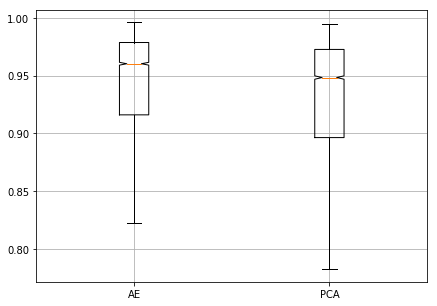

In [31]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2165439846404906
AE 2.695046473643087


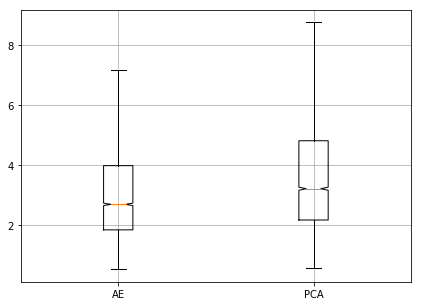

In [32]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# Super Deep Encoder

In [33]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_sdeep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sdeep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 80),
                                     activation_layer,
                                     nn.Linear(80, 60),
                                     activation_layer,
                                     nn.Linear(60, 45),
                                     activation_layer,
                                     nn.Linear(45, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, 8),
                                     activation_layer,
                                     nn.Linear(8, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 8),
                                     activation_layer,
                                     nn.Linear(8, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 45),
                                     activation_layer,
                                     nn.Linear(45, 60),
                                     activation_layer,
                                     nn.Linear(60, 80),
                                     activation_layer,
                                     nn.Linear(80, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [34]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_sdeep(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_sdeep(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52 = train_ae(ae_52, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_6_4', np.array(losses_54))
np.save('models/final_models/losses_6_2', np.array(losses_52))


# Saving Models
#torch.save(ae_54, 'models/final_models/ae_6_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/final_models/ae_6_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 44987
epoch [1/350000], loss:1525.60937500, avg:1525.60937500
epoch [101/350000], loss:605.55883789, avg:682.68450928
epoch [201/350000], loss:243.38990784, avg:239.24783325
epoch [301/350000], loss:224.39671326, avg:232.53262329
epoch [401/350000], loss:246.81797791, avg:227.63493347
epoch [501/350000], loss:227.87016296, avg:235.26908875
epoch [601/350000], loss:241.33094788, avg:234.00309753
epoch [701/350000], loss:220.37663269, avg:229.56282043
epoch [801/350000], loss:229.88412476, avg:224.35179138
epoch [901/350000], loss:225.31887817, avg:218.31846619
epoch [1001/350000], loss:221.11647034, avg:219.51037598
epoch [1101/350000], loss:172.81195068, avg:180.81103516
epoch [1201/350000], loss:169.44664001, avg:151.69737244
epoch [1301/350000], loss:140.90734863, avg:142.34532166
epoch [1401/350000], loss:128.35742188, avg:131.18653870
epoch [1501/350000], loss:145.62673950, avg:137.59059143
epoch [1601/350000], loss:143.19201660, avg:140.47250366
epoch [

epoch [14301/350000], loss:128.52021790, avg:128.97406006
epoch [14401/350000], loss:127.40160370, avg:127.46730042
epoch [14501/350000], loss:134.23660278, avg:125.81381989
epoch [14601/350000], loss:135.40379333, avg:126.99961090
epoch [14701/350000], loss:127.19817352, avg:128.08732605
epoch [14801/350000], loss:115.72617340, avg:126.03185272
epoch [14901/350000], loss:125.54792786, avg:125.34082031
epoch [15001/350000], loss:134.27157593, avg:131.68254089
epoch [15101/350000], loss:123.02795410, avg:125.88535309
epoch [15201/350000], loss:122.46582031, avg:128.62925720
epoch [15301/350000], loss:132.34866333, avg:126.60121918
epoch [15401/350000], loss:135.12998962, avg:127.17872620
epoch [15501/350000], loss:127.50391388, avg:125.25537109
epoch [15601/350000], loss:121.50117493, avg:126.65685272
epoch [15701/350000], loss:122.38090515, avg:127.55609131
epoch [15801/350000], loss:119.73557281, avg:124.97891998
epoch [15901/350000], loss:131.75186157, avg:126.46848297
epoch [16001/3

epoch [28501/350000], loss:109.93139648, avg:117.43206024
epoch [28601/350000], loss:124.04483032, avg:115.99167633
epoch [28701/350000], loss:124.14745331, avg:118.57098389
epoch [28801/350000], loss:115.66033173, avg:117.15036774
epoch [28901/350000], loss:118.29241180, avg:116.16584778
epoch [29001/350000], loss:117.98504639, avg:116.44773102
epoch [29101/350000], loss:118.31097412, avg:117.74533844
epoch [29201/350000], loss:115.94362640, avg:119.56423187
epoch [29301/350000], loss:122.08451080, avg:117.85499573
epoch [29401/350000], loss:122.00669861, avg:115.31113434
epoch [29501/350000], loss:114.99497986, avg:116.36846161
epoch [29601/350000], loss:111.39582062, avg:118.33552551
epoch [29701/350000], loss:117.66089630, avg:114.93275452
epoch [29801/350000], loss:109.85502625, avg:115.06520844
epoch [29901/350000], loss:113.17314911, avg:114.88813782
epoch [30001/350000], loss:109.66704559, avg:113.06191254
epoch [30101/350000], loss:116.34197235, avg:116.43412018
epoch [30201/3

epoch [42701/350000], loss:104.41854858, avg:108.68359375
epoch [42801/350000], loss:109.25719452, avg:108.91689301
epoch [42901/350000], loss:110.89895630, avg:108.84309387
epoch [43001/350000], loss:104.94687653, avg:107.77178192
epoch [43101/350000], loss:100.34962463, avg:106.38668060
epoch [43201/350000], loss:119.71367645, avg:108.98319244
epoch [43301/350000], loss:104.73797607, avg:106.94835663
epoch [43401/350000], loss:101.66542816, avg:108.24053955
epoch [43501/350000], loss:117.00955200, avg:108.34638977
epoch [43601/350000], loss:103.22528076, avg:108.39074707
epoch [43701/350000], loss:115.57646942, avg:108.68840790
epoch [43801/350000], loss:108.83609772, avg:109.30262756
epoch [43901/350000], loss:99.71712494, avg:106.23677063
epoch [44001/350000], loss:115.58559418, avg:107.85760498
epoch [44101/350000], loss:106.21236420, avg:108.13470459
epoch [44201/350000], loss:110.14614105, avg:108.63011932
epoch [44301/350000], loss:116.66915131, avg:107.10037994
epoch [44401/35

epoch [56901/350000], loss:100.61243439, avg:102.74271393
epoch [57001/350000], loss:101.62567902, avg:107.18659973
epoch [57101/350000], loss:103.54738617, avg:104.13844299
epoch [57201/350000], loss:96.99862671, avg:106.16381073
epoch [57301/350000], loss:114.33274841, avg:107.90815735
epoch [57401/350000], loss:103.94174957, avg:104.48802948
epoch [57501/350000], loss:106.89060211, avg:107.96703339
epoch [57601/350000], loss:115.13067627, avg:108.15964508
epoch [57701/350000], loss:104.83738708, avg:109.16153717
epoch [57801/350000], loss:115.22579193, avg:111.85090637
epoch [57901/350000], loss:105.68459320, avg:111.41719055
epoch [58001/350000], loss:107.60102844, avg:108.12697601
epoch [58101/350000], loss:105.54259491, avg:108.68163300
epoch [58201/350000], loss:102.39395142, avg:107.15439606
epoch [58301/350000], loss:105.45138550, avg:105.36602020
epoch [58401/350000], loss:103.13681030, avg:107.17765045
epoch [58501/350000], loss:108.52281189, avg:105.51859283
epoch [58601/35

epoch [71101/350000], loss:108.99495697, avg:102.69127655
epoch [71201/350000], loss:98.51263428, avg:100.75314331
epoch [71301/350000], loss:102.87565613, avg:101.78501892
epoch [71401/350000], loss:104.13677979, avg:103.29055023
epoch [71501/350000], loss:108.71431732, avg:104.80830383
epoch [71601/350000], loss:95.20786285, avg:102.95043945
epoch [71701/350000], loss:110.21294403, avg:102.71938324
epoch [71801/350000], loss:104.33201599, avg:103.25345612
epoch [71901/350000], loss:99.95147705, avg:104.33090973
epoch [72001/350000], loss:99.99751282, avg:102.06346130
epoch [72101/350000], loss:101.20771027, avg:101.41491699
epoch [72201/350000], loss:105.10952759, avg:105.33971405
epoch [72301/350000], loss:99.93509674, avg:102.04843140
epoch [72401/350000], loss:98.62346649, avg:102.47932434
epoch [72501/350000], loss:98.92689514, avg:102.64196777
epoch [72601/350000], loss:107.77437592, avg:104.16312408
epoch [72701/350000], loss:102.20751190, avg:103.72442627
epoch [72801/350000],

epoch [85301/350000], loss:100.12490082, avg:101.85439301
epoch [85401/350000], loss:109.57836914, avg:102.44951630
epoch [85501/350000], loss:98.24537659, avg:101.95445251
epoch [85601/350000], loss:101.28098297, avg:102.71773529
epoch [85701/350000], loss:112.39217377, avg:100.61300659
epoch [85801/350000], loss:103.35304260, avg:103.32946777
epoch [85901/350000], loss:97.08592224, avg:102.14997864
epoch [86001/350000], loss:107.85607910, avg:105.12297821
epoch [86101/350000], loss:99.16741943, avg:102.29084778
epoch [86201/350000], loss:97.91286469, avg:102.26726532
epoch [86301/350000], loss:101.92978668, avg:102.55136871
epoch [86401/350000], loss:106.33130646, avg:100.47119141
epoch [86501/350000], loss:100.46810150, avg:103.63553619
epoch [86601/350000], loss:102.72486877, avg:100.65856934
epoch [86701/350000], loss:98.86612701, avg:102.00450897
epoch [86801/350000], loss:103.36043549, avg:101.38143921
epoch [86901/350000], loss:97.87259674, avg:103.92729950
epoch [87001/350000]

epoch [99601/350000], loss:105.53919983, avg:104.93013763
epoch [99701/350000], loss:103.37557220, avg:102.33332062
epoch [99801/350000], loss:104.87758636, avg:104.75219727
epoch [99901/350000], loss:106.47755432, avg:105.42901611
epoch [100001/350000], loss:106.80119324, avg:103.55283356
epoch [100101/350000], loss:104.00804138, avg:102.18278503
epoch [100201/350000], loss:112.62243652, avg:104.97588348
epoch [100301/350000], loss:98.91370392, avg:100.56151581
epoch [100401/350000], loss:100.70696259, avg:102.23521423
epoch [100501/350000], loss:97.12908936, avg:99.56426239
epoch [100601/350000], loss:97.08194733, avg:101.25346375
epoch [100701/350000], loss:106.59107208, avg:103.45652008
epoch [100801/350000], loss:103.55761719, avg:100.77529144
epoch [100901/350000], loss:106.31814575, avg:100.29831696
epoch [101001/350000], loss:95.47217560, avg:99.98072052
epoch [101101/350000], loss:100.54662323, avg:101.81195831
epoch [101201/350000], loss:101.46011353, avg:99.58022308
epoch [1

epoch [113701/350000], loss:99.69689178, avg:100.82854462
epoch [113801/350000], loss:105.30006409, avg:102.81204987
epoch [113901/350000], loss:99.04084015, avg:103.50778961
epoch [114001/350000], loss:99.11996460, avg:102.34946442
epoch [114101/350000], loss:107.58465576, avg:104.41181946
epoch [114201/350000], loss:103.98534393, avg:103.07948303
epoch [114301/350000], loss:103.37907410, avg:100.83930206
epoch [114401/350000], loss:98.41544342, avg:100.40273285
epoch [114501/350000], loss:102.48290253, avg:102.30825043
epoch [114601/350000], loss:103.51586914, avg:101.01685333
epoch [114701/350000], loss:101.17029572, avg:103.66037750
epoch [114801/350000], loss:97.17472839, avg:101.95854187
epoch [114901/350000], loss:96.22312927, avg:102.58001709
epoch [115001/350000], loss:98.64725494, avg:102.86518860
epoch [115101/350000], loss:102.50465393, avg:104.20021820
epoch [115201/350000], loss:105.97238922, avg:103.15114594
epoch [115301/350000], loss:107.91866302, avg:102.96477509
epoc

epoch [127901/350000], loss:100.67246246, avg:101.19263458
epoch [128001/350000], loss:96.15094757, avg:99.79567719
epoch [128101/350000], loss:99.53002167, avg:100.06245422
epoch [128201/350000], loss:101.58536530, avg:99.69506073
epoch [128301/350000], loss:93.85534668, avg:97.32230377
epoch [128401/350000], loss:98.31884766, avg:100.77800751
epoch [128501/350000], loss:105.62372589, avg:100.03065491
epoch [128601/350000], loss:96.26672363, avg:99.93675232
epoch [128701/350000], loss:102.69716644, avg:100.89733124
epoch [128801/350000], loss:98.99818420, avg:100.47912598
epoch [128901/350000], loss:101.68626404, avg:98.94934845
epoch [129001/350000], loss:96.61469269, avg:101.38011169
epoch [129101/350000], loss:104.59773254, avg:101.65789032
epoch [129201/350000], loss:104.99991608, avg:99.03587341
epoch [129301/350000], loss:103.57608795, avg:97.94371796
epoch [129401/350000], loss:100.92744446, avg:99.57961273
epoch [129501/350000], loss:100.24859619, avg:98.29444885
epoch [129601

epoch [142201/350000], loss:101.81138611, avg:98.87545776
epoch [142301/350000], loss:100.11461639, avg:98.96309662
epoch [142401/350000], loss:97.58153534, avg:99.39455414
epoch [142501/350000], loss:93.63883972, avg:97.59566498
epoch [142601/350000], loss:99.92733765, avg:98.37318420
epoch [142701/350000], loss:104.05310822, avg:100.90692902
epoch [142801/350000], loss:94.65473938, avg:97.33224487
epoch [142901/350000], loss:101.28542328, avg:100.10604858
epoch [143001/350000], loss:93.91369629, avg:99.84494019
epoch [143101/350000], loss:103.91497803, avg:100.48564911
epoch [143201/350000], loss:92.27791595, avg:97.08292389
epoch [143301/350000], loss:96.61335754, avg:98.16909790
epoch [143401/350000], loss:94.93071747, avg:99.71620941
epoch [143501/350000], loss:102.03102112, avg:97.48394775
epoch [143601/350000], loss:96.11830902, avg:100.23696136
epoch [143701/350000], loss:104.31245422, avg:99.09351349
epoch [143801/350000], loss:96.92963409, avg:99.68510437
epoch [143901/350000

epoch [156401/350000], loss:96.38111115, avg:98.17759705
epoch [156501/350000], loss:103.46031952, avg:101.01798248
epoch [156601/350000], loss:97.67220306, avg:98.42210388
epoch [156701/350000], loss:96.31587982, avg:97.61445618
epoch [156801/350000], loss:98.67370605, avg:99.18180084
epoch [156901/350000], loss:93.70699310, avg:96.97062683
epoch [157001/350000], loss:98.26918793, avg:98.45636749
epoch [157101/350000], loss:102.29493713, avg:97.09443665
epoch [157201/350000], loss:98.65953064, avg:98.89511871
epoch [157301/350000], loss:97.15926361, avg:97.10115814
epoch [157401/350000], loss:93.84954834, avg:99.44335175
epoch [157501/350000], loss:97.52772522, avg:97.98366547
epoch [157601/350000], loss:95.47222900, avg:98.42710114
epoch [157701/350000], loss:101.12490082, avg:98.86685181
epoch [157801/350000], loss:98.87110138, avg:99.38777924
epoch [157901/350000], loss:89.53375244, avg:100.28667450
epoch [158001/350000], loss:99.70471954, avg:97.60655975
epoch [158101/350000], los

epoch [170701/350000], loss:101.46704865, avg:98.34780121
epoch [170801/350000], loss:96.64824677, avg:97.36184692
epoch [170901/350000], loss:93.62658691, avg:96.71553802
epoch [171001/350000], loss:101.38249969, avg:100.16446686
epoch [171101/350000], loss:101.08592224, avg:99.18363190
epoch [171201/350000], loss:99.48500824, avg:99.10263062
epoch [171301/350000], loss:97.89488220, avg:98.02233124
epoch [171401/350000], loss:101.55828094, avg:99.80712128
epoch [171501/350000], loss:99.76588440, avg:100.31156921
epoch [171601/350000], loss:95.87064362, avg:96.45197296
epoch [171701/350000], loss:98.01178741, avg:98.90672302
epoch [171801/350000], loss:98.71423340, avg:97.73146820
epoch [171901/350000], loss:96.28328705, avg:99.52124023
epoch [172001/350000], loss:103.06032562, avg:100.10656738
epoch [172101/350000], loss:98.80366516, avg:98.48604584
epoch [172201/350000], loss:95.62743378, avg:97.18312073
epoch [172301/350000], loss:99.73606110, avg:100.42050171
epoch [172401/350000],

epoch [185001/350000], loss:93.85860443, avg:99.33862305
epoch [185101/350000], loss:98.93786621, avg:99.91204834
epoch [185201/350000], loss:99.24154663, avg:99.07039642
epoch [185301/350000], loss:100.37075043, avg:98.77986145
epoch [185401/350000], loss:95.05740356, avg:98.54335022
epoch [185501/350000], loss:96.00511932, avg:99.50652313
epoch [185601/350000], loss:98.17388153, avg:99.75303650
epoch [185701/350000], loss:103.98222351, avg:100.35041809
epoch [185801/350000], loss:95.20195770, avg:97.86121368
epoch [185901/350000], loss:96.58914948, avg:100.78996277
epoch [186001/350000], loss:101.72705078, avg:98.54873657
epoch [186101/350000], loss:100.07669067, avg:100.04003906
epoch [186201/350000], loss:99.57772827, avg:98.47788239
epoch [186301/350000], loss:96.86921692, avg:96.92701721
epoch [186401/350000], loss:99.15263367, avg:98.52816010
epoch [186501/350000], loss:98.31356049, avg:98.83865356
epoch [186601/350000], loss:100.28340912, avg:98.05010223
epoch [186701/350000], 

epoch [199301/350000], loss:92.72911072, avg:98.36468506
epoch [199401/350000], loss:96.80239868, avg:98.48571014
epoch [199501/350000], loss:98.41460419, avg:101.91620636
epoch [199601/350000], loss:99.75276947, avg:103.05366516
epoch [199701/350000], loss:97.27039337, avg:99.70919800
epoch [199801/350000], loss:99.62348938, avg:97.68050385
epoch [199901/350000], loss:97.42203522, avg:99.57465363
epoch [200001/350000], loss:94.52684021, avg:98.84777832
epoch [200101/350000], loss:101.61972809, avg:99.20638275
epoch [200201/350000], loss:94.13484955, avg:97.17731476
epoch [200301/350000], loss:96.24057007, avg:97.88909912
epoch [200401/350000], loss:99.07299042, avg:97.26296997
epoch [200501/350000], loss:97.58683777, avg:97.51329803
epoch [200601/350000], loss:100.96393585, avg:100.34566498
epoch [200701/350000], loss:94.35873413, avg:98.92634583
epoch [200801/350000], loss:102.96729279, avg:98.68608093
epoch [200901/350000], loss:101.73011780, avg:99.93661499
epoch [201001/350000], l

epoch [213501/350000], loss:97.25829315, avg:98.35792542
epoch [213601/350000], loss:107.55106354, avg:100.09568787
epoch [213701/350000], loss:101.42518616, avg:99.39290619
epoch [213801/350000], loss:100.41073608, avg:98.12120819
epoch [213901/350000], loss:103.43312836, avg:98.22298431
epoch [214001/350000], loss:94.86887360, avg:95.95427704
epoch [214101/350000], loss:92.58973694, avg:96.96021271
epoch [214201/350000], loss:94.41485596, avg:97.15991211
epoch [214301/350000], loss:97.47509003, avg:98.09386444
epoch [214401/350000], loss:94.17366028, avg:97.32775879
epoch [214501/350000], loss:104.06149292, avg:99.22778320
epoch [214601/350000], loss:98.74511719, avg:98.63254547
epoch [214701/350000], loss:97.71588135, avg:98.11737823
epoch [214801/350000], loss:99.98217773, avg:97.61692810
epoch [214901/350000], loss:97.87535095, avg:98.66188812
epoch [215001/350000], loss:105.35498047, avg:98.80471039
epoch [215101/350000], loss:95.84805298, avg:98.65657806
epoch [215201/350000], l

epoch [227701/350000], loss:95.52989960, avg:97.02754974
epoch [227801/350000], loss:96.91926575, avg:96.90353394
epoch [227901/350000], loss:101.56771851, avg:99.36766815
epoch [228001/350000], loss:103.37996674, avg:100.70497894
epoch [228101/350000], loss:100.67404938, avg:100.95384979
epoch [228201/350000], loss:94.92919922, avg:100.00231934
epoch [228301/350000], loss:98.36346436, avg:98.27862549
epoch [228401/350000], loss:96.56805420, avg:99.22312927
epoch [228501/350000], loss:100.62469482, avg:99.16365814
epoch [228601/350000], loss:100.00145721, avg:97.59830475
epoch [228701/350000], loss:96.94119263, avg:97.65917969
epoch [228801/350000], loss:102.74393463, avg:98.96871185
epoch [228901/350000], loss:98.19645691, avg:96.90193939
epoch [229001/350000], loss:96.38590240, avg:99.14311218
epoch [229101/350000], loss:99.17377472, avg:99.93878937
epoch [229201/350000], loss:96.93146515, avg:97.72994232
epoch [229301/350000], loss:95.28008270, avg:97.97753143
epoch [229401/350000],

epoch [241901/350000], loss:97.56444550, avg:101.32370758
epoch [242001/350000], loss:97.36756897, avg:101.86270905
epoch [242101/350000], loss:98.61280823, avg:103.15749359
epoch [242201/350000], loss:101.29750824, avg:101.21501160
epoch [242301/350000], loss:108.87219238, avg:102.40111542
epoch [242401/350000], loss:100.93054199, avg:101.09590912
epoch [242501/350000], loss:99.37846375, avg:101.07233429
epoch [242601/350000], loss:106.62221527, avg:100.59616852
epoch [242701/350000], loss:97.12324524, avg:101.79994965
epoch [242801/350000], loss:100.41395569, avg:103.84303284
epoch [242901/350000], loss:106.69952393, avg:102.22518158
epoch [243001/350000], loss:104.47071075, avg:104.23054504
epoch [243101/350000], loss:102.90846252, avg:100.86701965
epoch [243201/350000], loss:103.28872681, avg:102.13671112
epoch [243301/350000], loss:102.03855896, avg:103.45652008
epoch [243401/350000], loss:104.67755127, avg:101.14678192
epoch [243501/350000], loss:100.24146271, avg:100.98786163
ep

epoch [256101/350000], loss:104.27645874, avg:101.67926025
epoch [256201/350000], loss:100.86785126, avg:99.71717072
epoch [256301/350000], loss:97.77047729, avg:101.46111298
epoch [256401/350000], loss:100.39286804, avg:100.45828247
epoch [256501/350000], loss:102.17459869, avg:100.20007324
epoch [256601/350000], loss:94.86662292, avg:97.72297668
epoch [256701/350000], loss:94.76821899, avg:98.22138977
epoch [256801/350000], loss:105.20136261, avg:100.54788208
epoch [256901/350000], loss:98.85431671, avg:98.21505737
epoch [257001/350000], loss:95.02191162, avg:97.35481262
epoch [257101/350000], loss:96.41928864, avg:98.13149261
epoch [257201/350000], loss:103.40576935, avg:97.35370636
epoch [257301/350000], loss:101.57109833, avg:100.23656464
epoch [257401/350000], loss:96.15011597, avg:98.99083710
epoch [257501/350000], loss:96.66205597, avg:100.15343475
epoch [257601/350000], loss:97.27850342, avg:99.28992462
epoch [257701/350000], loss:98.99560547, avg:98.17494965
epoch [257801/350

epoch [270301/350000], loss:94.56888580, avg:96.92408752
epoch [270401/350000], loss:100.15834045, avg:96.81448364
epoch [270501/350000], loss:104.76624298, avg:98.63925171
epoch [270601/350000], loss:99.96923065, avg:99.72359467
epoch [270701/350000], loss:100.39860535, avg:97.23744965
epoch [270801/350000], loss:102.73668671, avg:100.51873016
epoch [270901/350000], loss:102.50210571, avg:97.37805176
epoch [271001/350000], loss:99.40615082, avg:96.03112793
epoch [271101/350000], loss:98.36880493, avg:95.97148895
epoch [271201/350000], loss:103.01078796, avg:98.46126556
epoch [271301/350000], loss:96.88963318, avg:95.37149811
epoch [271401/350000], loss:95.40771484, avg:96.91908264
epoch [271501/350000], loss:94.00726318, avg:96.72219849
epoch [271601/350000], loss:94.76621246, avg:96.24535370
epoch [271701/350000], loss:102.20040894, avg:98.18764496
epoch [271801/350000], loss:94.69892883, avg:98.52759552
epoch [271901/350000], loss:100.22057343, avg:97.75154877
epoch [272001/350000],

epoch [284501/350000], loss:95.87289429, avg:98.76134491
epoch [284601/350000], loss:98.26428223, avg:99.05095673
epoch [284701/350000], loss:95.48140717, avg:97.15612030
epoch [284801/350000], loss:96.28851318, avg:96.12837219
epoch [284901/350000], loss:91.76863861, avg:95.68323517
epoch [285001/350000], loss:94.68512726, avg:95.88156128
epoch [285101/350000], loss:92.10641479, avg:95.14149475
epoch [285201/350000], loss:97.63073730, avg:96.48645782
epoch [285301/350000], loss:102.09815216, avg:95.64807129
epoch [285401/350000], loss:100.43666077, avg:97.28310394
epoch [285501/350000], loss:95.35496521, avg:93.07244110
epoch [285601/350000], loss:97.77608490, avg:97.51268005
epoch [285701/350000], loss:94.32984924, avg:97.42640686
epoch [285801/350000], loss:92.58087921, avg:95.86837006
epoch [285901/350000], loss:93.09677887, avg:95.08428192
epoch [286001/350000], loss:98.51464081, avg:96.08104706
epoch [286101/350000], loss:94.82732391, avg:95.86266327
epoch [286201/350000], loss:9

epoch [298801/350000], loss:92.95999908, avg:97.20229340
epoch [298901/350000], loss:97.46204376, avg:97.17757416
epoch [299001/350000], loss:101.33998108, avg:98.25030518
epoch [299101/350000], loss:91.25851440, avg:98.79283905
epoch [299201/350000], loss:94.81519318, avg:97.80925751
epoch [299301/350000], loss:103.49344635, avg:99.84569550
epoch [299401/350000], loss:95.70277405, avg:98.80721283
epoch [299501/350000], loss:97.81252289, avg:97.19643402
epoch [299601/350000], loss:97.42841339, avg:99.44730377
epoch [299701/350000], loss:102.45238495, avg:98.72084808
epoch [299801/350000], loss:97.68704987, avg:98.64332581
epoch [299901/350000], loss:102.76827240, avg:97.74848175
epoch [300001/350000], loss:97.83544159, avg:97.26912689
epoch [300101/350000], loss:101.18782806, avg:100.45818329
epoch [300201/350000], loss:102.98999786, avg:96.39771271
epoch [300301/350000], loss:107.06640625, avg:100.73737335
epoch [300401/350000], loss:100.61750031, avg:100.64665985
epoch [300501/350000

epoch [313101/350000], loss:98.28368378, avg:95.54847717
epoch [313201/350000], loss:99.24960327, avg:96.29274750
epoch [313301/350000], loss:98.26050568, avg:95.07835388
epoch [313401/350000], loss:95.74074554, avg:95.98662567
epoch [313501/350000], loss:92.82889557, avg:96.52394104
epoch [313601/350000], loss:100.23834991, avg:95.18328857
epoch [313701/350000], loss:93.72005463, avg:96.12374115
epoch [313801/350000], loss:91.43093109, avg:92.83133698
epoch [313901/350000], loss:96.66731262, avg:95.25874329
epoch [314001/350000], loss:96.38599396, avg:94.27812958
epoch [314101/350000], loss:91.56492615, avg:95.50026703
epoch [314201/350000], loss:92.26686096, avg:95.36705780
epoch [314301/350000], loss:91.89186096, avg:93.70980072
epoch [314401/350000], loss:95.23549652, avg:94.73011780
epoch [314501/350000], loss:102.29084778, avg:94.93414307
epoch [314601/350000], loss:98.55220795, avg:95.27346039
epoch [314701/350000], loss:92.67311859, avg:93.36211395
epoch [314801/350000], loss:9

epoch [327501/350000], loss:90.43525696, avg:96.89493561
epoch [327601/350000], loss:95.89513397, avg:95.43585205
epoch [327701/350000], loss:99.60757446, avg:95.34639740
epoch [327801/350000], loss:92.41225433, avg:92.83161926
epoch [327901/350000], loss:99.03717041, avg:95.05668640
epoch [328001/350000], loss:92.59421539, avg:95.34007263
epoch [328101/350000], loss:89.25010681, avg:92.63990021
epoch [328201/350000], loss:94.63990021, avg:95.75798035
epoch [328301/350000], loss:94.79582214, avg:96.36061859
epoch [328401/350000], loss:98.73620605, avg:96.65850067
epoch [328501/350000], loss:95.58248901, avg:95.51125336
epoch [328601/350000], loss:99.43518066, avg:96.16634369
epoch [328701/350000], loss:101.94554138, avg:94.00493622
epoch [328801/350000], loss:103.25222015, avg:96.62406158
epoch [328901/350000], loss:97.21640778, avg:96.14237976
epoch [329001/350000], loss:95.75316620, avg:95.80837250
epoch [329101/350000], loss:91.18304443, avg:95.66942596
epoch [329201/350000], loss:9

epoch [341901/350000], loss:96.76127625, avg:95.53622437
epoch [342001/350000], loss:98.50519562, avg:92.71300507
epoch [342101/350000], loss:93.59297180, avg:92.22100067
epoch [342201/350000], loss:91.20378113, avg:93.48757935
epoch [342301/350000], loss:88.23426819, avg:95.12081146
epoch [342401/350000], loss:93.38745880, avg:92.85454559
epoch [342501/350000], loss:93.00874329, avg:94.14662933
epoch [342601/350000], loss:102.34806824, avg:95.78241730
epoch [342701/350000], loss:95.87831116, avg:95.60177612
epoch [342801/350000], loss:99.83058167, avg:95.83117676
epoch [342901/350000], loss:95.13217163, avg:98.28993225
epoch [343001/350000], loss:94.06829071, avg:94.36539459
epoch [343101/350000], loss:92.04734802, avg:94.07769775
epoch [343201/350000], loss:88.78769684, avg:94.06742096
epoch [343301/350000], loss:95.43274689, avg:96.24008179
epoch [343401/350000], loss:92.41415405, avg:95.54148102
epoch [343501/350000], loss:93.55860901, avg:94.26430511
epoch [343601/350000], loss:93

In [35]:
ae_1 = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_6_4.pt', map_location=lambda storage, loc: storage)

AE 0.9627281330142067
PCA 0.948394974723552
Original 1.0
Baseline 0.9429411251524722


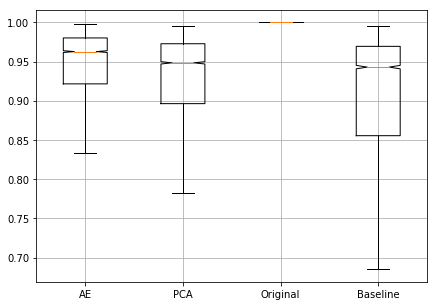

In [36]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca, 'Original': electrode_data_test, "Baseline": comp_pca(0)}
find_correlation_coeff(d)

In [37]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')

PCA 3.2165439846406096
AE 2.580681431814437
Baseline 10.241149235814499


PCA 3.2165439846406096
AE 2.580681431814437
Baseline 10.241149235814499


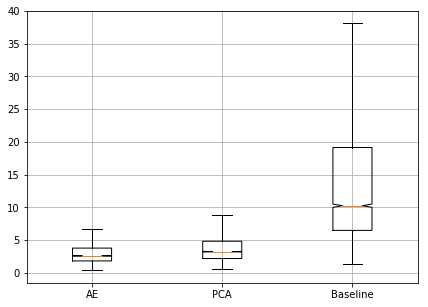

In [38]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse, 'Baseline': baseline})

In [39]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [40]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

AE 0.9627281330142067
PCA 0.948394974723552
Baseline 0.9429411251524722
[('AE', 0.9627281330142067), ('PCA', 0.948394974723552), ('Baseline', 0.9429411251524722)]
Baseline Value:  0.9429411251524722
AE Value:  0.9627281330142067
PCA Value:  0.948394974723552

 AE improvement:  2.0984351338515386
PCA improvement:  0.5783870727027609


In [41]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

Baseline Value:  10.241149235814499
AE Value:  2.580681431814437
PCA Value:  3.2165439846406096

 AE improvement:  74.80086099332006
PCA improvement:  68.59196257591894


# Asymmetric Single Decoder

TOTAL PARAMETERS FOR MODEL: 12250
epoch [1/350000], loss:1605.69335938, avg:1605.69335938
epoch [101/350000], loss:1611.74194336, avg:1518.28015137
epoch [201/350000], loss:1347.55688477, avg:1420.13183594
epoch [301/350000], loss:1415.24291992, avg:1335.48156738
epoch [401/350000], loss:1230.62890625, avg:1263.42211914
epoch [501/350000], loss:1229.88195801, avg:1212.26513672
epoch [601/350000], loss:1098.32373047, avg:1115.32897949
epoch [701/350000], loss:1066.95129395, avg:1068.89685059
epoch [801/350000], loss:957.52514648, avg:948.58685303
epoch [901/350000], loss:819.23608398, avg:851.66290283
epoch [1001/350000], loss:753.31933594, avg:763.58166504
epoch [1101/350000], loss:667.46502686, avg:657.52850342
epoch [1201/350000], loss:583.07110596, avg:582.45385742
epoch [1301/350000], loss:495.63235474, avg:515.45648193
epoch [1401/350000], loss:435.19338989, avg:442.95938110
epoch [1501/350000], loss:401.76242065, avg:393.61145020
epoch [1601/350000], loss:390.08770752, avg:358.36

epoch [14301/350000], loss:129.69355774, avg:142.32925415
epoch [14401/350000], loss:134.84078979, avg:139.36103821
epoch [14501/350000], loss:143.89599609, avg:140.35249329
epoch [14601/350000], loss:144.29579163, avg:143.78947449
epoch [14701/350000], loss:158.95732117, avg:147.39250183
epoch [14801/350000], loss:135.95773315, avg:146.95625305
epoch [14901/350000], loss:153.40507507, avg:143.91815186
epoch [15001/350000], loss:137.54751587, avg:140.65296936
epoch [15101/350000], loss:142.76832581, avg:145.35322571
epoch [15201/350000], loss:148.97644043, avg:143.18971252
epoch [15301/350000], loss:152.56500244, avg:141.64335632
epoch [15401/350000], loss:137.33828735, avg:143.41764832
epoch [15501/350000], loss:136.52172852, avg:140.30017090
epoch [15601/350000], loss:155.43356323, avg:139.77767944
epoch [15701/350000], loss:155.68902588, avg:143.75793457
epoch [15801/350000], loss:148.69294739, avg:146.83311462
epoch [15901/350000], loss:140.92662048, avg:142.80393982
epoch [16001/3

epoch [28501/350000], loss:136.85327148, avg:143.08686829
epoch [28601/350000], loss:145.64894104, avg:141.85658264
epoch [28701/350000], loss:145.14715576, avg:141.93984985
epoch [28801/350000], loss:130.16653442, avg:142.60867310
epoch [28901/350000], loss:138.95252991, avg:141.31736755
epoch [29001/350000], loss:148.64929199, avg:138.95217896
epoch [29101/350000], loss:138.20660400, avg:142.75242615
epoch [29201/350000], loss:145.20130920, avg:143.75024414
epoch [29301/350000], loss:140.50677490, avg:141.45104980
epoch [29401/350000], loss:144.16720581, avg:144.55155945
epoch [29501/350000], loss:136.99142456, avg:141.36427307
epoch [29601/350000], loss:146.41972351, avg:141.21463013
epoch [29701/350000], loss:149.08908081, avg:138.10131836
epoch [29801/350000], loss:153.79804993, avg:144.05931091
epoch [29901/350000], loss:147.46708679, avg:138.91040039
epoch [30001/350000], loss:152.49528503, avg:141.98808289
epoch [30101/350000], loss:133.60156250, avg:143.71574402
epoch [30201/3

epoch [42701/350000], loss:141.91030884, avg:137.07461548
epoch [42801/350000], loss:141.42236328, avg:142.19506836
epoch [42901/350000], loss:143.25552368, avg:140.69857788
epoch [43001/350000], loss:137.42869568, avg:137.22094727
epoch [43101/350000], loss:140.36549377, avg:138.52410889
epoch [43201/350000], loss:129.48872375, avg:140.17225647
epoch [43301/350000], loss:132.72177124, avg:140.50253296
epoch [43401/350000], loss:139.81338501, avg:141.33894348
epoch [43501/350000], loss:138.93855286, avg:140.09332275
epoch [43601/350000], loss:147.37153625, avg:140.99972534
epoch [43701/350000], loss:144.52796936, avg:142.67393494
epoch [43801/350000], loss:137.01428223, avg:142.97593689
epoch [43901/350000], loss:140.77766418, avg:142.85679626
epoch [44001/350000], loss:135.26655579, avg:140.31407166
epoch [44101/350000], loss:135.07458496, avg:143.41073608
epoch [44201/350000], loss:132.24627686, avg:135.58642578
epoch [44301/350000], loss:136.59930420, avg:141.46296692
epoch [44401/3

epoch [56901/350000], loss:141.46525574, avg:137.14750671
epoch [57001/350000], loss:139.81332397, avg:142.08843994
epoch [57101/350000], loss:142.35833740, avg:134.87178040
epoch [57201/350000], loss:137.94326782, avg:137.59574890
epoch [57301/350000], loss:137.04194641, avg:136.79051208
epoch [57401/350000], loss:141.40414429, avg:140.66001892
epoch [57501/350000], loss:138.37776184, avg:138.53927612
epoch [57601/350000], loss:134.49858093, avg:141.45195007
epoch [57701/350000], loss:152.08767700, avg:139.69380188
epoch [57801/350000], loss:144.92794800, avg:138.43707275
epoch [57901/350000], loss:132.35322571, avg:140.54504395
epoch [58001/350000], loss:135.80722046, avg:140.04817200
epoch [58101/350000], loss:130.41339111, avg:136.45071411
epoch [58201/350000], loss:138.55473328, avg:138.85920715
epoch [58301/350000], loss:136.41166687, avg:138.54069519
epoch [58401/350000], loss:129.73641968, avg:138.08433533
epoch [58501/350000], loss:134.98414612, avg:139.52944946
epoch [58601/3

epoch [71101/350000], loss:141.16098022, avg:138.36845398
epoch [71201/350000], loss:128.97219849, avg:136.30763245
epoch [71301/350000], loss:128.94067383, avg:138.53117371
epoch [71401/350000], loss:126.63548279, avg:138.78956604
epoch [71501/350000], loss:140.91964722, avg:137.17999268
epoch [71601/350000], loss:137.29473877, avg:134.77671814
epoch [71701/350000], loss:138.73970032, avg:133.18074036
epoch [71801/350000], loss:129.92253113, avg:137.31364441
epoch [71901/350000], loss:136.71812439, avg:137.38774109
epoch [72001/350000], loss:132.32093811, avg:133.68910217
epoch [72101/350000], loss:135.97499084, avg:141.14105225
epoch [72201/350000], loss:135.84288025, avg:137.87107849
epoch [72301/350000], loss:138.90863037, avg:136.17483521
epoch [72401/350000], loss:132.48471069, avg:135.17106628
epoch [72501/350000], loss:133.85133362, avg:134.90000916
epoch [72601/350000], loss:133.40303040, avg:135.44523621
epoch [72701/350000], loss:133.56513977, avg:134.43519592
epoch [72801/3

epoch [85301/350000], loss:141.12068176, avg:136.03141785
epoch [85401/350000], loss:143.56404114, avg:135.57661438
epoch [85501/350000], loss:141.69252014, avg:136.86784363
epoch [85601/350000], loss:133.50741577, avg:133.68846130
epoch [85701/350000], loss:129.34277344, avg:137.57592773
epoch [85801/350000], loss:138.04167175, avg:135.36076355
epoch [85901/350000], loss:143.41372681, avg:137.41114807
epoch [86001/350000], loss:140.22541809, avg:138.55299377
epoch [86101/350000], loss:141.68946838, avg:138.44296265
epoch [86201/350000], loss:145.12947083, avg:134.65220642
epoch [86301/350000], loss:134.00730896, avg:136.75550842
epoch [86401/350000], loss:138.65042114, avg:137.68531799
epoch [86501/350000], loss:147.80357361, avg:137.73945618
epoch [86601/350000], loss:133.83023071, avg:138.16822815
epoch [86701/350000], loss:139.91050720, avg:134.90133667
epoch [86801/350000], loss:139.58923340, avg:133.89248657
epoch [86901/350000], loss:128.63810730, avg:137.23931885
epoch [87001/3

epoch [99501/350000], loss:140.39329529, avg:135.22039795
epoch [99601/350000], loss:131.90478516, avg:134.71009827
epoch [99701/350000], loss:131.24636841, avg:135.56437683
epoch [99801/350000], loss:136.12297058, avg:133.19398499
epoch [99901/350000], loss:131.88195801, avg:136.21405029
epoch [100001/350000], loss:125.24565125, avg:129.89315796
epoch [100101/350000], loss:136.64802551, avg:134.69273376
epoch [100201/350000], loss:121.75522614, avg:135.32933044
epoch [100301/350000], loss:124.42792511, avg:134.73973083
epoch [100401/350000], loss:126.71864319, avg:136.06010437
epoch [100501/350000], loss:146.48698425, avg:138.70739746
epoch [100601/350000], loss:143.48200989, avg:136.61161804
epoch [100701/350000], loss:138.69287109, avg:134.79507446
epoch [100801/350000], loss:133.68894958, avg:135.37982178
epoch [100901/350000], loss:124.76171875, avg:136.61975098
epoch [101001/350000], loss:142.66590881, avg:134.88067627
epoch [101101/350000], loss:133.34393311, avg:135.24453735
ep

epoch [113401/350000], loss:125.31888580, avg:133.57415771
epoch [113501/350000], loss:134.25886536, avg:134.03570557
epoch [113601/350000], loss:127.82735443, avg:134.70671082
epoch [113701/350000], loss:138.04103088, avg:133.89648438
epoch [113801/350000], loss:128.31773376, avg:129.97402954
epoch [113901/350000], loss:122.27590942, avg:132.96293640
epoch [114001/350000], loss:132.00474548, avg:133.58778381
epoch [114101/350000], loss:142.84156799, avg:133.91629028
epoch [114201/350000], loss:128.99055481, avg:134.06454468
epoch [114301/350000], loss:135.83764648, avg:131.86184692
epoch [114401/350000], loss:141.55397034, avg:135.38769531
epoch [114501/350000], loss:133.47467041, avg:134.41581726
epoch [114601/350000], loss:138.80210876, avg:132.60827637
epoch [114701/350000], loss:127.20019531, avg:137.38931274
epoch [114801/350000], loss:126.81127930, avg:134.57119751
epoch [114901/350000], loss:137.88696289, avg:133.07334900
epoch [115001/350000], loss:129.20802307, avg:136.225341

epoch [127301/350000], loss:132.43811035, avg:131.39950562
epoch [127401/350000], loss:138.21716309, avg:131.32577515
epoch [127501/350000], loss:129.14532471, avg:132.40332031
epoch [127601/350000], loss:126.03931427, avg:131.33226013
epoch [127701/350000], loss:133.86795044, avg:133.73645020
epoch [127801/350000], loss:129.87940979, avg:130.21395874
epoch [127901/350000], loss:133.08697510, avg:135.02217102
epoch [128001/350000], loss:129.07063293, avg:134.64169312
epoch [128101/350000], loss:127.98283386, avg:131.65316772
epoch [128201/350000], loss:135.07057190, avg:135.55804443
epoch [128301/350000], loss:130.12670898, avg:132.32353210
epoch [128401/350000], loss:140.74272156, avg:132.67295837
epoch [128501/350000], loss:143.64340210, avg:133.51023865
epoch [128601/350000], loss:134.11585999, avg:131.83457947
epoch [128701/350000], loss:132.86413574, avg:130.68983459
epoch [128801/350000], loss:128.75938416, avg:132.32786560
epoch [128901/350000], loss:138.09446716, avg:128.922576

epoch [141201/350000], loss:135.03192139, avg:130.90571594
epoch [141301/350000], loss:127.04111481, avg:130.57850647
epoch [141401/350000], loss:137.35522461, avg:130.47094727
epoch [141501/350000], loss:140.28038025, avg:136.95822144
epoch [141601/350000], loss:132.79962158, avg:130.61892700
epoch [141701/350000], loss:138.83572388, avg:132.74600220
epoch [141801/350000], loss:140.08459473, avg:132.95390320
epoch [141901/350000], loss:128.99179077, avg:131.33106995
epoch [142001/350000], loss:137.87754822, avg:129.66526794
epoch [142101/350000], loss:137.30158997, avg:130.76194763
epoch [142201/350000], loss:132.61233521, avg:128.97389221
epoch [142301/350000], loss:123.31620789, avg:129.70506287
epoch [142401/350000], loss:129.31356812, avg:130.72752380
epoch [142501/350000], loss:136.53277588, avg:135.34269714
epoch [142601/350000], loss:122.69209290, avg:133.26231384
epoch [142701/350000], loss:136.59548950, avg:134.24235535
epoch [142801/350000], loss:121.07472229, avg:129.845001

epoch [155101/350000], loss:121.86799622, avg:129.82572937
epoch [155201/350000], loss:149.33531189, avg:134.91197205
epoch [155301/350000], loss:129.14303589, avg:132.40196228
epoch [155401/350000], loss:132.63804626, avg:133.56332397
epoch [155501/350000], loss:135.37596130, avg:133.08955383
epoch [155601/350000], loss:141.16166687, avg:134.56295776
epoch [155701/350000], loss:130.02902222, avg:132.75682068
epoch [155801/350000], loss:134.94149780, avg:134.70875549
epoch [155901/350000], loss:140.74644470, avg:133.23719788
epoch [156001/350000], loss:133.47895813, avg:132.88739014
epoch [156101/350000], loss:121.57578278, avg:128.18707275
epoch [156201/350000], loss:129.16069031, avg:128.53326416
epoch [156301/350000], loss:129.51155090, avg:132.24290466
epoch [156401/350000], loss:125.29343414, avg:133.32890320
epoch [156501/350000], loss:126.05499268, avg:129.71057129
epoch [156601/350000], loss:137.17131042, avg:130.61393738
epoch [156701/350000], loss:124.49330902, avg:130.493713

epoch [169001/350000], loss:130.18511963, avg:129.67866516
epoch [169101/350000], loss:134.17900085, avg:134.08816528
epoch [169201/350000], loss:128.90875244, avg:128.12673950
epoch [169301/350000], loss:126.70908356, avg:130.13285828
epoch [169401/350000], loss:125.91883850, avg:130.42672729
epoch [169501/350000], loss:126.27210236, avg:129.71836853
epoch [169601/350000], loss:123.65831757, avg:131.67320251
epoch [169701/350000], loss:131.40155029, avg:128.93127441
epoch [169801/350000], loss:121.08797455, avg:130.80503845
epoch [169901/350000], loss:134.00439453, avg:132.44761658
epoch [170001/350000], loss:135.27757263, avg:128.60871887
epoch [170101/350000], loss:130.08265686, avg:131.73506165
epoch [170201/350000], loss:119.57679749, avg:127.87599945
epoch [170301/350000], loss:134.49711609, avg:132.22581482
epoch [170401/350000], loss:127.26575470, avg:130.58929443
epoch [170501/350000], loss:123.03387451, avg:130.17333984
epoch [170601/350000], loss:152.36241150, avg:135.817367

epoch [182901/350000], loss:127.70255280, avg:131.52484131
epoch [183001/350000], loss:122.92611694, avg:129.76182556
epoch [183101/350000], loss:131.66583252, avg:127.63940430
epoch [183201/350000], loss:131.32839966, avg:132.46345520
epoch [183301/350000], loss:126.35755920, avg:129.22326660
epoch [183401/350000], loss:140.77160645, avg:130.85324097
epoch [183501/350000], loss:129.34301758, avg:132.84220886
epoch [183601/350000], loss:129.71479797, avg:133.65446472
epoch [183701/350000], loss:143.90869141, avg:130.65977478
epoch [183801/350000], loss:128.15277100, avg:132.01936340
epoch [183901/350000], loss:143.40623474, avg:132.52273560
epoch [184001/350000], loss:143.35896301, avg:131.52433777
epoch [184101/350000], loss:124.82437897, avg:130.48680115
epoch [184201/350000], loss:130.24269104, avg:131.69319153
epoch [184301/350000], loss:128.91658020, avg:132.49371338
epoch [184401/350000], loss:146.36253357, avg:133.79734802
epoch [184501/350000], loss:132.19659424, avg:131.666000

epoch [196801/350000], loss:128.29714966, avg:129.46870422
epoch [196901/350000], loss:118.92841339, avg:127.42730713
epoch [197001/350000], loss:138.39637756, avg:133.80667114
epoch [197101/350000], loss:127.18637848, avg:130.03639221
epoch [197201/350000], loss:128.40284729, avg:130.88455200
epoch [197301/350000], loss:129.89649963, avg:129.94462585
epoch [197401/350000], loss:121.17672729, avg:129.71109009
epoch [197501/350000], loss:125.60929871, avg:135.40798950
epoch [197601/350000], loss:131.28567505, avg:131.56030273
epoch [197701/350000], loss:128.54219055, avg:135.33663940
epoch [197801/350000], loss:134.70429993, avg:133.90220642
epoch [197901/350000], loss:137.55932617, avg:131.10191345
epoch [198001/350000], loss:127.06736755, avg:131.06230164
epoch [198101/350000], loss:118.43130493, avg:131.65005493
epoch [198201/350000], loss:126.11924744, avg:133.54191589
epoch [198301/350000], loss:135.39788818, avg:129.85403442
epoch [198401/350000], loss:126.50492859, avg:133.482543

epoch [210701/350000], loss:133.39292908, avg:129.85783386
epoch [210801/350000], loss:131.11961365, avg:127.63643646
epoch [210901/350000], loss:140.33195496, avg:133.56086731
epoch [211001/350000], loss:126.84883881, avg:129.72982788
epoch [211101/350000], loss:130.12902832, avg:128.27677917
epoch [211201/350000], loss:139.97509766, avg:131.13223267
epoch [211301/350000], loss:132.20645142, avg:130.17253113
epoch [211401/350000], loss:137.83921814, avg:130.09179688
epoch [211501/350000], loss:130.65255737, avg:132.95428467
epoch [211601/350000], loss:131.70886230, avg:128.73730469
epoch [211701/350000], loss:133.14979553, avg:131.42163086
epoch [211801/350000], loss:139.79394531, avg:130.38461304
epoch [211901/350000], loss:126.39974213, avg:131.88345337
epoch [212001/350000], loss:132.87150574, avg:130.02854919
epoch [212101/350000], loss:134.00094604, avg:129.45701599
epoch [212201/350000], loss:131.74389648, avg:130.86096191
epoch [212301/350000], loss:132.90609741, avg:132.064193

epoch [224601/350000], loss:119.18153381, avg:133.03868103
epoch [224701/350000], loss:119.54373932, avg:129.14356995
epoch [224801/350000], loss:136.80345154, avg:132.21087646
epoch [224901/350000], loss:127.61821747, avg:129.66397095
epoch [225001/350000], loss:123.29853821, avg:129.35691833
epoch [225101/350000], loss:124.10585022, avg:127.59394836
epoch [225201/350000], loss:127.82373810, avg:129.81443787
epoch [225301/350000], loss:128.05235291, avg:133.24650574
epoch [225401/350000], loss:131.96261597, avg:129.79496765
epoch [225501/350000], loss:132.61654663, avg:131.45783997
epoch [225601/350000], loss:137.11212158, avg:132.40351868
epoch [225701/350000], loss:133.24415588, avg:132.19267273
epoch [225801/350000], loss:134.65144348, avg:130.30131531
epoch [225901/350000], loss:130.31716919, avg:132.55387878
epoch [226001/350000], loss:138.26490784, avg:135.64555359
epoch [226101/350000], loss:128.78872681, avg:128.80776978
epoch [226201/350000], loss:140.38954163, avg:131.647262

epoch [238501/350000], loss:127.70729065, avg:126.86380768
epoch [238601/350000], loss:127.04972076, avg:131.01907349
epoch [238701/350000], loss:125.61116028, avg:131.60942078
epoch [238801/350000], loss:127.15991974, avg:131.48364258
epoch [238901/350000], loss:130.66859436, avg:133.12536621
epoch [239001/350000], loss:137.60845947, avg:131.48696899
epoch [239101/350000], loss:137.01358032, avg:130.19619751
epoch [239201/350000], loss:135.75791931, avg:127.67350006
epoch [239301/350000], loss:131.53422546, avg:131.62651062
epoch [239401/350000], loss:127.12731934, avg:129.73147583
epoch [239501/350000], loss:123.94481659, avg:127.31546783
epoch [239601/350000], loss:126.05908966, avg:130.59365845
epoch [239701/350000], loss:140.16458130, avg:129.56034851
epoch [239801/350000], loss:143.00970459, avg:130.04966736
epoch [239901/350000], loss:139.35910034, avg:131.94102478
epoch [240001/350000], loss:125.31180573, avg:127.86788177
epoch [240101/350000], loss:122.76769257, avg:132.141586

epoch [252401/350000], loss:133.60275269, avg:130.71234131
epoch [252501/350000], loss:142.07250977, avg:133.52243042
epoch [252601/350000], loss:125.25818634, avg:128.50535583
epoch [252701/350000], loss:129.93031311, avg:128.85227966
epoch [252801/350000], loss:129.47319031, avg:130.08811951
epoch [252901/350000], loss:126.40528107, avg:128.41349792
epoch [253001/350000], loss:130.94812012, avg:131.38157654
epoch [253101/350000], loss:134.27197266, avg:132.63059998
epoch [253201/350000], loss:139.93983459, avg:132.09353638
epoch [253301/350000], loss:136.66891479, avg:130.07550049
epoch [253401/350000], loss:128.65722656, avg:131.82986450
epoch [253501/350000], loss:129.87017822, avg:133.04515076
epoch [253601/350000], loss:116.92343140, avg:130.61148071
epoch [253701/350000], loss:129.45783997, avg:132.03321838
epoch [253801/350000], loss:135.58303833, avg:132.74162292
epoch [253901/350000], loss:150.16497803, avg:133.36160278
epoch [254001/350000], loss:129.17501831, avg:128.037063

epoch [266301/350000], loss:133.97030640, avg:130.21508789
epoch [266401/350000], loss:122.30567169, avg:135.31449890
epoch [266501/350000], loss:130.72785950, avg:131.74963379
epoch [266601/350000], loss:140.96333313, avg:133.70918274
epoch [266701/350000], loss:129.44555664, avg:129.28729248
epoch [266801/350000], loss:130.15385437, avg:132.23590088
epoch [266901/350000], loss:127.63925171, avg:126.83884430
epoch [267001/350000], loss:125.66063690, avg:129.98619080
epoch [267101/350000], loss:124.32838440, avg:130.80973816
epoch [267201/350000], loss:125.71330261, avg:129.89801025
epoch [267301/350000], loss:126.31135559, avg:128.96116638
epoch [267401/350000], loss:124.09985352, avg:127.95458221
epoch [267501/350000], loss:134.09834290, avg:131.30789185
epoch [267601/350000], loss:132.39175415, avg:130.66246033
epoch [267701/350000], loss:133.87028503, avg:130.44041443
epoch [267801/350000], loss:131.39723206, avg:131.12814331
epoch [267901/350000], loss:131.03443909, avg:130.439376

epoch [280201/350000], loss:132.80194092, avg:133.82847595
epoch [280301/350000], loss:130.25515747, avg:130.24853516
epoch [280401/350000], loss:129.49243164, avg:129.87767029
epoch [280501/350000], loss:131.20051575, avg:126.75019836
epoch [280601/350000], loss:122.30005646, avg:129.88478088
epoch [280701/350000], loss:135.74818420, avg:130.33517456
epoch [280801/350000], loss:131.21336365, avg:130.41142273
epoch [280901/350000], loss:126.17192078, avg:129.53837585
epoch [281001/350000], loss:136.47322083, avg:129.73477173
epoch [281101/350000], loss:139.21301270, avg:133.47325134
epoch [281201/350000], loss:122.07749939, avg:126.67805481
epoch [281301/350000], loss:130.66958618, avg:126.22651672
epoch [281401/350000], loss:128.54046631, avg:131.00004578
epoch [281501/350000], loss:134.83554077, avg:127.21404266
epoch [281601/350000], loss:134.05453491, avg:130.42156982
epoch [281701/350000], loss:127.91712952, avg:131.35374451
epoch [281801/350000], loss:130.74011230, avg:131.290054

epoch [294101/350000], loss:129.54095459, avg:132.40344238
epoch [294201/350000], loss:120.58710480, avg:129.09579468
epoch [294301/350000], loss:125.51425171, avg:129.68658447
epoch [294401/350000], loss:136.36241150, avg:131.14161682
epoch [294501/350000], loss:134.74638367, avg:127.67846680
epoch [294601/350000], loss:124.07419586, avg:131.72917175
epoch [294701/350000], loss:139.39186096, avg:132.01130676
epoch [294801/350000], loss:134.49986267, avg:126.79886627
epoch [294901/350000], loss:138.29302979, avg:132.41181946
epoch [295001/350000], loss:129.37231445, avg:129.74836731
epoch [295101/350000], loss:141.28482056, avg:131.81999207
epoch [295201/350000], loss:134.48497009, avg:129.03860474
epoch [295301/350000], loss:133.22747803, avg:130.26712036
epoch [295401/350000], loss:134.70843506, avg:132.36967468
epoch [295501/350000], loss:128.19714355, avg:133.09757996
epoch [295601/350000], loss:144.47163391, avg:132.30717468
epoch [295701/350000], loss:120.99109650, avg:130.220718

epoch [308001/350000], loss:120.79472351, avg:126.60523987
epoch [308101/350000], loss:129.38945007, avg:131.84507751
epoch [308201/350000], loss:127.83750916, avg:129.84667969
epoch [308301/350000], loss:140.78541565, avg:130.70185852
epoch [308401/350000], loss:125.58958435, avg:130.52203369
epoch [308501/350000], loss:137.51190186, avg:130.12307739
epoch [308601/350000], loss:132.30828857, avg:131.73132324
epoch [308701/350000], loss:124.07101440, avg:129.49710083
epoch [308801/350000], loss:132.45234680, avg:129.82164001
epoch [308901/350000], loss:126.66361237, avg:129.51701355
epoch [309001/350000], loss:124.12095642, avg:130.91880798
epoch [309101/350000], loss:131.62228394, avg:129.26325989
epoch [309201/350000], loss:142.32090759, avg:131.51390076
epoch [309301/350000], loss:131.13473511, avg:130.44615173
epoch [309401/350000], loss:134.04319763, avg:127.81990814
epoch [309501/350000], loss:137.09870911, avg:127.51096344
epoch [309601/350000], loss:131.93959045, avg:128.174728

epoch [321901/350000], loss:131.33041382, avg:130.03836060
epoch [322001/350000], loss:129.06994629, avg:128.56584167
epoch [322101/350000], loss:118.78147888, avg:133.40478516
epoch [322201/350000], loss:125.99848175, avg:129.27561951
epoch [322301/350000], loss:122.29287720, avg:131.30941772
epoch [322401/350000], loss:131.25987244, avg:132.70982361
epoch [322501/350000], loss:133.64341736, avg:129.47915649
epoch [322601/350000], loss:127.81200409, avg:130.93437195
epoch [322701/350000], loss:134.92007446, avg:131.07366943
epoch [322801/350000], loss:122.84377289, avg:127.99208069
epoch [322901/350000], loss:136.35708618, avg:131.35305786
epoch [323001/350000], loss:126.22534943, avg:132.63427734
epoch [323101/350000], loss:130.49636841, avg:129.50514221
epoch [323201/350000], loss:128.20204163, avg:130.42396545
epoch [323301/350000], loss:130.62925720, avg:127.76417542
epoch [323401/350000], loss:133.35621643, avg:131.38793945
epoch [323501/350000], loss:149.03889465, avg:134.550659

epoch [335801/350000], loss:128.75811768, avg:129.66270447
epoch [335901/350000], loss:133.09747314, avg:128.44909668
epoch [336001/350000], loss:133.95555115, avg:132.34068298
epoch [336101/350000], loss:125.03273773, avg:128.99075317
epoch [336201/350000], loss:130.19178772, avg:129.07080078
epoch [336301/350000], loss:133.86837769, avg:131.32815552
epoch [336401/350000], loss:140.76216125, avg:133.54406738
epoch [336501/350000], loss:139.26878357, avg:131.76646423
epoch [336601/350000], loss:132.50814819, avg:133.85858154
epoch [336701/350000], loss:129.14428711, avg:127.97576141
epoch [336801/350000], loss:132.17506409, avg:132.22657776
epoch [336901/350000], loss:120.89456177, avg:130.15959167
epoch [337001/350000], loss:132.35000610, avg:131.62496948
epoch [337101/350000], loss:136.75503540, avg:129.92204285
epoch [337201/350000], loss:127.28555298, avg:132.44238281
epoch [337301/350000], loss:131.75273132, avg:129.86567688
epoch [337401/350000], loss:120.68028259, avg:130.251205

epoch [349701/350000], loss:123.73815155, avg:130.56553650
epoch [349801/350000], loss:128.51113892, avg:131.77177429
epoch [349901/350000], loss:132.72099304, avg:130.16781616
AE 0.9479679047255409
PCA 0.9483949747235509


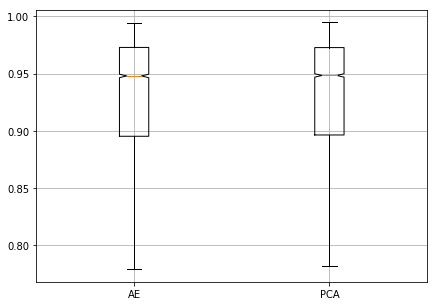

PCA 3.2165439846404675
AE 3.232069882925652


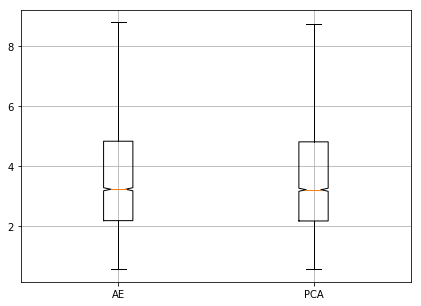

In [42]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_sd(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sd, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 51))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_var(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_82 = autoencoder_sd(length, embedding_size).cuda()
ae_82.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_82.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_82 = train_ae(ae_82, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_5_4', np.array(losses_54))
np.save('models/final_models/losses_8_2', np.array(losses_82))


# Saving Models
#torch.save(ae_54, 'models/final_models/ae_5_4.pt') #Saving the autoencoder model
torch.save(ae_82, 'models/final_models/ae_8_2.pt') #Saving the autoencoder model

ae_1 = torch.load('models/final_models/ae_8_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})